In [436]:
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
import numpy as np
from pandas_summary import DataFrameSummary
import pandas_profiling as pp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import random
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
import graphviz 
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from pandas.util import hash_pandas_object
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, StratifiedKFold, cross_val_score
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
%matplotlib inline
from IPython.core.debugger import set_trace


In [438]:
from dateutil.parser import parse
train_set_df = pd.read_csv("train_set.csv", parse_dates = ['timestamp'], date_parser = parse )
test_set_df = pd.read_csv("test_set.csv", parse_dates = ['timestamp'], date_parser = parse )

In [439]:
y_train_raw = train_set_df.label
train_set_grouped_by_patients = train_set_df.groupby('patient_id')

# EDA

**Initial examination of the raw data**

In [440]:
train_set_df.describe()

_temporary_index_column     patient_id  measurement_x  measurement_y  \
count            799999.000000  799999.000000  799999.000000  799999.000000   
mean             400000.000000   12848.728287       0.652244       0.148045   
std              230939.963337    7418.937484       0.241065       0.204066   
min                   1.000000       0.000000      -0.621091      -1.045211   
25%              200000.500000    6378.000000       0.478952       0.016042   
50%              400000.000000   12830.000000       0.611564       0.128319   
75%              599999.500000   19275.000000       0.797053       0.252838   
max              799999.000000   25705.000000       1.905430       1.506080   

       measurement_z          label  
count  799999.000000  799999.000000  
mean        0.073163       0.439943  
std         0.059840       0.691995  
min        -0.004350       0.000000  
25%         0.033487       0.000000  
50%         0.058148       0.000000  
75%         0.094124       1.000000  
max         0.478850       2.000000

**The distribution of labels over the raw data is approx: 68% - class 0, 20% - class 1, and 12% - class 2**

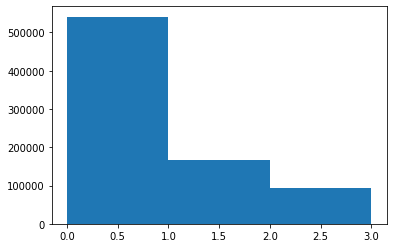

In [26]:
counts = plt.hist(y_train_raw, bins =  [0,1,2,3] )

In [27]:
counts[0]/counts[0].sum()*100

array([67.62883454, 20.74802594, 11.62313953])

**The labels are attributes of patients, not of specific samples (all patient's samples have the same label )** 

In [28]:
inds_0 = y_train_raw==0
inds_1 = y_train_raw==1
inds_2 = y_train_raw==2

In [29]:
patiends_0_set = set(train_set_df[inds_0]['patient_id'])
patiends_1_set = set(train_set_df[inds_1]['patient_id'])
patiends_2_set = set(train_set_df[inds_2]['patient_id'])

In [30]:
patiends_0_set.intersection(patiends_1_set)

set()

In [31]:
patiends_0_set.intersection(patiends_2_set)

set()

In [32]:
patiends_1_set.intersection(patiends_2_set)

set()

**Each patient's data consists of 3 time series. The number of samples in these series across the patients varies between 1 (single sample) and nearly 100**

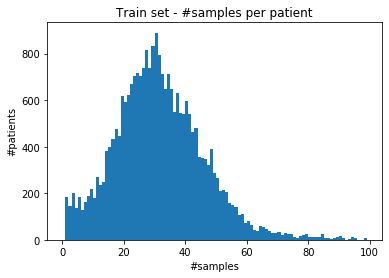

In [33]:
train_set_samples_sizes = [len(pdf[1]) for pdf in train_set_grouped_by_patients]
plt.hist(train_set_samples_sizes, bins = np.arange(0,100));
plt.title("Train set - #samples per patient");
plt.xlabel("#samples");
plt.ylabel("#patients");

**The test set has similar distribution, which means, in particular, that we'll need to predict labels of series consisting of a single time sample**

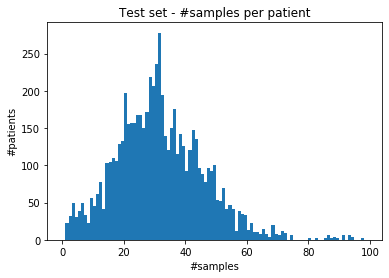

In [34]:
test_set_samples_sizes = [len(pdf[1]) for pdf in test_set_df.groupby('patient_id')]
plt.hist(test_set_samples_sizes, bins = np.arange(0,100));
plt.title("Test set - #samples per patient");
plt.xlabel("#samples");
plt.ylabel("#patients");

**Since the timedelta between each sample is 50ms, the corresponding series durations vary between 0 sec (single sample) to nearly 5 sec (100 samples)** 

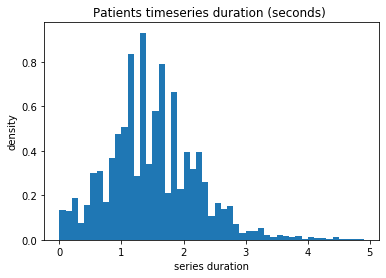

In [35]:
train_set_samples_durations = [(pdf[1]['timestamp'].iloc[-1] - pdf[1]['timestamp'].iloc[0]).total_seconds() for pdf in train_set_grouped_by_patients]
plt.hist(train_set_samples_durations, density=True, bins = np.arange(0, 5, 0.1));
plt.title("Patients timeseries duration (seconds) ");
plt.xlabel("series duration");
plt.ylabel("density");

**Some series are inconsistent in terms of their sizes and durations. Below we see some series with 5 samples (corresponding to 0.2 sec), whose duration is less than 0.2 sec** 

In [36]:
np.array(train_set_samples_durations)[np.array(train_set_samples_sizes)==5]

array([0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.15, 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.15, 0.15,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.15, 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.15, 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.15, 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.  , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.15, 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.

**Let's find the one with duration 0**

In [37]:
np.argmax((np.array(train_set_samples_sizes)==5) & (np.array(train_set_samples_durations) < 0.05))

18186

In [38]:
train_set_grouped_by_patients.get_group(18186)

_temporary_index_column                  timestamp  measurement_x  \
566557                   566558 2015-01-02 09:08:28.683331       0.925543   
566558                   566559 2015-01-02 09:08:28.683331       0.928349   
566559                   566560 2015-01-02 09:08:28.683331       0.931236   
566560                   566561 2015-01-02 09:08:28.683331       0.934203   
566561                   566562 2015-01-02 09:08:28.683331       0.937251   

        measurement_y  measurement_z  label  
566557      -0.028669       0.097464      1  
566558      -0.038518       0.101493      1  
566559      -0.048345       0.104182      1  
566560      -0.058147       0.107254      1  
566561      -0.067925       0.110500      1

**The timestamps are identical across all the samples. Here's another example:**

In [39]:
train_set_grouped_by_patients.get_group(np.argmax((np.array(train_set_samples_sizes)==5) & (np.array(train_set_samples_durations) == 0.1)))

_temporary_index_column                  timestamp  measurement_x  \
691313                   691314 2013-08-20 16:42:45.478373       0.934248   
691314                   691315 2013-08-20 16:42:45.478373       0.937080   
691315                   691316 2013-08-20 16:42:45.578373       0.939844   
691316                   691317 2013-08-20 16:42:45.578373       0.942538   
691317                   691318 2013-08-20 16:42:45.578373       0.945163   

        measurement_y  measurement_z  label  
691313       0.226638       0.053605      1  
691314       0.233343       0.057909      1  
691315       0.240076       0.058216      1  
691316       0.246837       0.060546      1  
691317       0.253626       0.064965      1

**Seems that the measurements behave properly (they are not constant in time), thus it's a bug in the timestamps registration. We can either remove such samples as outliers or fix their timestamps based on their number of samples.
In order to decide between the options, let's see home many patients have this discrepancy, and of which type**

In [40]:
all_inconsistent_indices = ((np.array(train_set_samples_sizes) - 1)*0.05 - np.array(train_set_samples_durations)) > 0.00001
print(f"there are {all_inconsistent_indices.sum()} patients whose time series duration is shorter than their 50ms*#samples")
all_inconsistent_indices_upper = ((np.array(train_set_samples_sizes) - 1)*0.05 - np.array(train_set_samples_durations)) < - 0.00001
print(f"there are {all_inconsistent_indices_upper.sum()} patients whose time series duration is longer than their 50ms*#samples")

there are 2527 patients whose time series duration is shorter than their 50ms*#samples
there are 0 patients whose time series duration is longer than their 50ms*#samples


**This is more than 10% - we don't want to just throw them away. We also see that the duration is bounded by 50ms*#samples. So I'll go with the second option - correcting the timestamps. This will be done when extracting the features**


## TimeSeries - acquaintance 

**Since the class is a property of the patient (rather than a sample), let's examine the per-patient classes.**

**The classes proportions remain similar to the raw samples ones.**

there are 25706 patients altogether


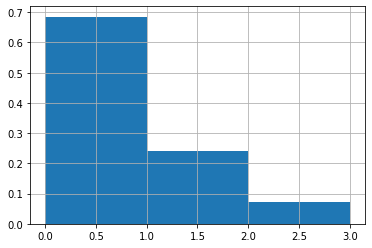

In [7]:
patients_classes_df = train_set_grouped_by_patients.nth(0)['label']
print(f"there are {len(patients_classes_df)} patients altogether")
patients_classes_df.hist(bins=[0,1,2,3], density=True);
y_per_patient = patients_classes_df.values

**Some utility functions for visualiation**

In [5]:
#Plot a patient timeseries, optionally with the regressed approximations superimposed (this comes later on)
def plot_patient_lines(patient_id, extracted_features = None, plot_ax = None):
    if plot_ax is None:
        fig_p, ax_p = plt.subplots()
    else:
        ax_p = plot_ax
    
    curr_patient_df = train_set_grouped_by_patients.get_group(patient_id)
    first_timestamp = curr_patient_df['timestamp'].iloc[0]
    curr_patient_df.index = list(map(lambda ts : (ts -first_timestamp).total_seconds()*1000, curr_patient_df['timestamp']))
    curr_patient_df[['measurement_x', 'measurement_y', 'measurement_z']].plot(ax=ax_p)
    if extracted_features is not None:
        coefs = extracted_features[:9].reshape(3,3).T
        x_regr = curr_patient_df.index.values
        x_mat = np.array([np.ones(len(x_regr)), x_regr, x_regr*x_regr ]).T
        curr_patient_df_approx = pd.DataFrame( x_mat.dot(coefs), 
                                              columns = ['measurement_x_regr', 'measurement_y_regr', 'measurement_z_regr'], 
                                                index = curr_patient_df.index
                                             )
        curr_patient_df_approx[['measurement_x_regr', 'measurement_y_regr', 'measurement_z_regr']].plot(ax=ax_p, style='--')
    ax_p.set_title(f"Patient {patient_id} timeseries")
    ax_p.set_xlabel("time from first timestamp (ms)")
    return len(curr_patient_df), ax_p

#Choose n_patient random patients of class patient_class
def choose_rand_patients( n_patients, patient_class ):
    if patient_class not in [0,1,2]:
        raise Exception("Specified patient_class is not in existing classes set: [0,1,2]")
    patient_class_inds = y_per_patient==patient_class
    num_class_patients = sum(patient_class_inds)
    if n_patients > num_class_patients:
        raise Exception("Specified num samples {} exceeds the number of patients of requested class {}".format(n_patients, patient_class))
    selected_class_inds = random.sample(range(0, num_class_patients), n_patients)
    selected_patients = patients_classes_df[patient_class_inds].index[selected_class_inds]
    return selected_patients.values


#Plot mis-classified instances of a given class
def plot_mis_classified(y_true, y_pred, class_label, num_mis, num_ok, fp_or_fn):
    pass
    

**Let's view some timeseries of each of the classes**

In [6]:
patients_ids = choose_rand_patients(1,1)
plot_patient_lines(patients_ids[0])

NameError: name 'y_per_patient' is not defined

**Typical and less typical classes timeseries**

Based on sproradic visual inspection of the timelines. Left images are the more typical, right ones seems less typical to each class.  

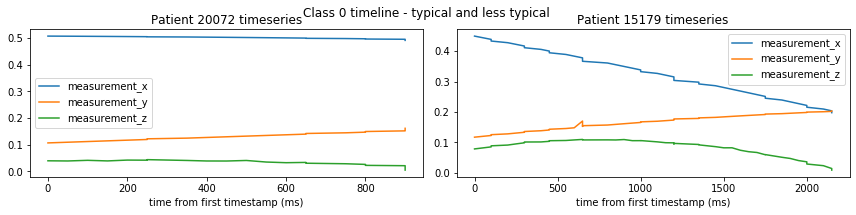

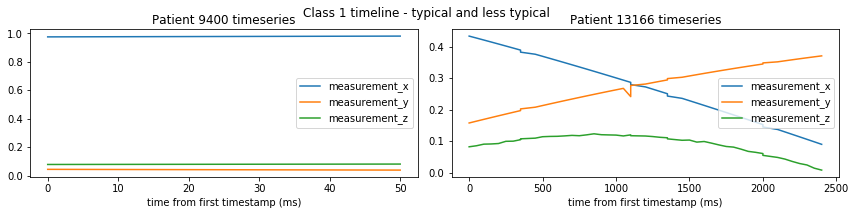

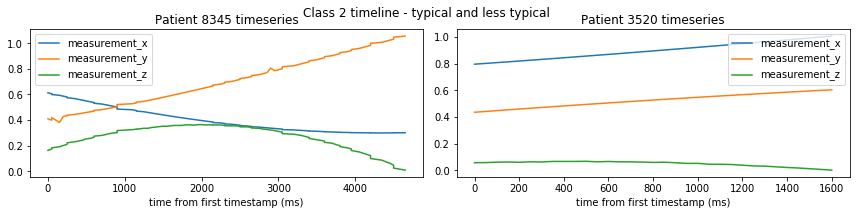

In [7]:
fig_0, (ax_0_typical, ax_0_non_typical) = plt.subplots(1,2)
fig_0.set_size_inches(12, 3)
plot_patient_lines(20072, plot_ax=ax_0_typical)
plot_patient_lines(15179, plot_ax=ax_0_non_typical)
fig_0.suptitle("Class 0 timeline - typical and less typical \n")
plt.tight_layout()

fig_1, (ax_1_typical, ax_1_non_typical) = plt.subplots(1,2)
fig_1.set_size_inches(12, 3)
plot_patient_lines(9400, plot_ax=ax_1_typical)
plot_patient_lines(13166, plot_ax=ax_1_non_typical)
fig_1.suptitle("Class 1 timeline - typical and less typical \n")
plt.tight_layout()

fig_2, (ax_2_typical, ax_2_non_typical) = plt.subplots(1,2)
fig_2.set_size_inches(12, 3)
fig_2.suptitle("Class 2 timeline - typical and less typical \n")
plot_patient_lines(8345, plot_ax=ax_2_typical)
plot_patient_lines(3520, plot_ax=ax_2_non_typical) 
plt.tight_layout()


### Duplicate patients removal###


In [441]:
#We can do that more efficiently - not essential here.
patients_as_list = list(train_set_grouped_by_patients)
len(patients_as_list)

25706

In [442]:
from collections import defaultdict

def patient_to_hash_tuple( patient_df ):
    return tuple(hash_pandas_object( (patient_df[['measurement_x', 'measurement_y', 'measurement_z']]*100000000).round().T))

d = {}
dupes = defaultdict(list)
uniques = []
for i in range(len(patients_as_list)):
    curr_hash = patient_to_hash_tuple( patients_as_list[i][1])
    if curr_hash in d:
        dupes[d[curr_hash]].append(i)
    else:
        d[curr_hash] = i
        uniques.append(i)

    

In [444]:
pd.Series(uniques).to_csv("unique_patients_indices.csv", index=False)

In [445]:
unique_patients_dfs = [patients_as_list[i] for i in uniques]

In [446]:
len(unique_patients_dfs)

6294

**Intermediate summary**

- Each patient is characterized by his/her 3 timeseries.  
- Visual inspection indicates that each class has a typical footprint in terms of its signals and their mutual configuration.
- A reasonable direction would be to represent each signal as a 1st or 2nd order polynomial, and use the coefficient as the features set for each patient.
- We can possibly add more features - e.g. whether or not signals intersect (typical to class 2), the average distance between signals (typically the y and z signals in class 1 are close), zero (or other level) crossing, etc. But let's start as simple as possible.

# Features engineering

In [447]:
#Returns the intersection points of the two lines, measured in distance from the first x coordinate.
# Returns -1 if no intersection occurs in the measured interval 
def find_intersection_points(x, coefs_vec1, coefs_vec2):

    rts = np.roots(np.flip(coefs_vec2-coefs_vec1))
#     print(f"In find_intersection_points. initial roots are {rts} ")
    rts[np.iscomplex(rts)] = -1
    rts[ rts > x[-1]] = -1
    rts[ rts < x[0]] = -1
    if len(rts) == 0:
        rts = [-1, -1]
    if len(rts) == 1:
        rts = [-1, rts[0]]
    return sorted(np.real(rts))

def find_average_dist(x,  coefs_vec1, coefs_vec2):
    p = np.poly1d(np.flip(coefs_vec2-coefs_vec1))
    return np.mean(p(x)**2)
    

# Utility functions to generate the features. 
extraction_schemes = ['parabola']
ts_handling_scheme = ['use_ts', 'create_x']

def extract_signals_params(signals_df, extraction_scheme, ts_handling_scheme, add_avg_dists):
   
    timestamps = signals_df.loc[:, 'timestamp']
   
    first_timestamp =  timestamps.iloc[0]
    if ts_handling_scheme == 'use_ts':
        x = np.array(list(map(lambda ts : (ts -first_timestamp).total_seconds()*1000, timestamps)))
    else:
        x = np.arange(0, len(timestamps)*50, 50) 
           
    x_full = np.array([x, x*x]).T #When the extraction_schemt is 'parabole', actually.
    sigs =  signals_df.loc[:, ['measurement_x', 'measurement_y', 'measurement_z']].values
    #Regress each signal to a 2nd order polynomial
    reg = LinearRegression().fit(x_full, sigs )
#     set_trace()
    coefs_mat = np.concatenate((np.array([reg.intercept_]).T, reg.coef_), axis=1)
    #Explicitly adding the intial value is redundant, since x starts at 0, hence the intercept is just this initial value
    coefs_vec = list(coefs_mat.reshape(1,-1)[0])
    
    intersection_x_y = find_intersection_points(x, coefs_mat[0,:], coefs_mat[1,:])
    intersection_x_z = find_intersection_points(x, coefs_mat[0,:], coefs_mat[2,:])
    intersection_y_z = find_intersection_points(x, coefs_mat[1,:], coefs_mat[2,:])
   
    features_to_concat = [coefs_vec, 
                           intersection_x_y, intersection_x_z, intersection_y_z]
    
                           

    if add_avg_dists:
        average_dist_x_y = find_average_dist(x, coefs_mat[0,:], coefs_mat[1,:])
        average_dist_x_z = find_average_dist(x, coefs_mat[0,:], coefs_mat[2,:])
        average_dist_y_z = find_average_dist(x, coefs_mat[1,:], coefs_mat[2,:])
        features_to_concat += [[average_dist_x_y], [average_dist_x_z], [average_dist_y_z]]
    

    ret = np.concatenate(tuple(features_to_concat)).tolist()
#     print(f"Now returning ret of type {type(ret)}")
#     print(ret)
    return ret
        
    
def extract_single_patient_features( patient_df, extraction_scheme, ts_handling_scheme, add_avg_dists ):
    patient_id = patient_df['patient_id'].iloc[0]
#     patient_features = []
    curr_line_params = extract_signals_params(patient_df, extraction_scheme, ts_handling_scheme, add_avg_dists)
#     patient_features += curr_line_params
#     return patient_features
#     print(f"Curr_line_params shape: {curr_line_params.shape}")
    return curr_line_params
        
    
def extract_features(in_dfs, extraction_scheme='parabola', ts_handling_scheme='use_ts', add_avg_dists = True):
    #TODO: input sanity checks
    X = []
    y = []
    iter_over = in_dfs.groupby('patient_id') if type(in_dfs) ==  pd.DataFrame else in_dfs
    for _,patient_df in iter_over:
        extracted_features = extract_single_patient_features( patient_df, extraction_scheme, ts_handling_scheme, add_avg_dists )
     
#         print(f"Appending features of shape {extracted_features.shape}")
        X.append(extracted_features )
#         print(np.array(X).shape)
#         if len(X) == 388:
#             set_trace()
        if 'label' in patient_df:
            y.append(patient_df['label'].iloc[0])
    features_names = ['meas_{}_a{}'.format(i,j) for i in ['x', 'y', 'z'] for j in range(3)]
    intersection_names = ['intersect_x_y_1', 'intersect_x_y_2', 'intersect_x_z_1', 'intersect_x_z_2',  'intersect_y_z_1', 'intersect_y_z_2']
    avg_dist_names = ['avg_dist_x_y', 'avg_dist_x_z', 'avg_dist_y_z']
    
    all_features_names = features_names + intersection_names
    if add_avg_dists:
        all_features_names += avg_dist_names
    
    return np.array(X), np.array(y),  all_features_names




In [448]:
# 'create_x' means we ignore the actual timestamps and use 50ms intervals between each successive samples.
#X, y, features_names  = extract_features(train_set_df, ts_handling_scheme='create_x')
X, y, features_names  = extract_features(unique_patients_dfs, ts_handling_scheme='create_x', add_avg_dists= True)
# X, y, features_names  = extract_features(unique_patients_dfs, ts_handling_scheme='create_x', )


In [449]:
features_names

['meas_x_a0',
 'meas_x_a1',
 'meas_x_a2',
 'meas_y_a0',
 'meas_y_a1',
 'meas_y_a2',
 'meas_z_a0',
 'meas_z_a1',
 'meas_z_a2',
 'intersect_x_y_1',
 'intersect_x_y_2',
 'intersect_x_z_1',
 'intersect_x_z_2',
 'intersect_y_z_1',
 'intersect_y_z_2',
 'avg_dist_x_y',
 'avg_dist_x_z',
 'avg_dist_y_z']

In [451]:
X.shape

(6294, 18)

In [507]:
X_scaled =  preprocessing.StandardScaler().fit(X).transform(X)

**Let's check how well this model encodes the timeseries**

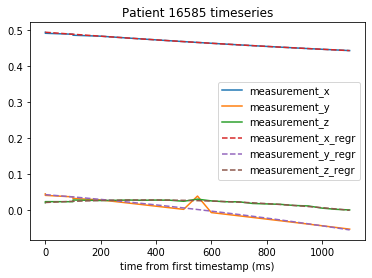

In [23]:
plot_patient_lines(uniques[4058], X[4058,:]);

**Visualize $X|y$, just to get a feeling of how well the features are seperable.**

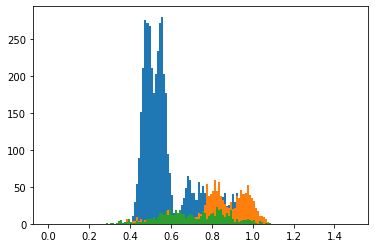

In [143]:
x_0 = X[ y==0, :]
x_1 = X[ y==1, :]
x_2 = X[ y==2, :]

x_0_scaled = X_scaled[ y==0, :]
x_1_scaled = X_scaled[ y==1, :]
x_2_scaled = X_scaled[ y==2, :]



#Compare a0  between all classes 
fig_x_given_y, ax_x_given_y = plt.subplots()
bins_f8 = np.arange(-0.0000001, 0.00000001, 0.000000001)
bins_f0 = np.arange(0, 1.5, 0.01)
bins_f2 = np.arange(-0.00000004, 0.00000004, 0.000000001)
bins_f3 = np.arange(-0.2, 0.6, 0.01)
ax_x_given_y.hist(x_0[:,0], bins=bins_f0);
ax_x_given_y.hist(x_1[:,0], bins=bins_f0);
ax_x_given_y.hist(x_2[:,0], bins=bins_f0);


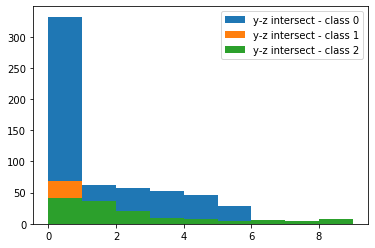

In [149]:
#Compare 1st y-z intersection  between all classes 
fig_x_given_y_intersect_yz, ax_x_given_y_intersect_yz = plt.subplots()
bins_f_1st_intersection = np.arange(0, 10, 1)
ax_x_given_y_intersect_yz.hist(x_0_scaled[:,14], label = 'y-z intersect - class 0', bins=bins_f_1st_intersection);
ax_x_given_y_intersect_yz.hist(x_1_scaled[:,14], label = 'y-z intersect - class 1', bins=bins_f_1st_intersection);
ax_x_given_y_intersect_yz.hist(x_2_scaled[:,14], label = 'y-z intersect - class 2', bins=bins_f_1st_intersection);

# ax_x_given_y_intersect_yz.hist(x_0_scaled[:,13], label = 'y-z intersect - class 0');
# ax_x_given_y_intersect_yz.hist(x_1_scaled[:,13], label = 'y-z intersect - class 1');
# ax_x_given_y_intersect_yz.hist(x_2_scaled[:,13], label = 'y-z intersect - class 2');
plt.legend()

plt.legend()
# bins_f8 = np.arange(-0.0000001, 0.00000001, 0.000000001)
# bins_f0 = np.arange(0, 1.5, 0.01)
# bins_f2 = np.arange(-0.00000004, 0.00000004, 0.000000001)
# bins_f3 = np.arange(-0.2, 0.6, 0.01)
# ax_x_given_y_intersect_yz.hist(x_0[:,9], bins=bins_f0);
# ax_x_given_y_intersect_yz.hist(x_1[:,9], bins=bins_f0);
# ax_x_given_y_intersect_yz.hist(x_2[:,9], bins=bins_f0);

**3d visualization (3 same order coefficients of the timeseries) indicate that classes 0, 1 are more seperable than class 2.** 

In [139]:
import plotly.express as px
i=2
j=5
k=8

def plot_3d_features(i, j, k, title):
    fig = go.Figure(data=[go.Scatter3d(x= x_0[:,i], y=x_0[:,j], z=x_0[:,k],
                                       mode='markers', name='class 0', 
                                       marker=dict(
                                        size=2,
                                        opacity=0.6
                                    ))])
    fig.add_trace( go.Scatter3d(x= x_1[:,i], y=x_1[:,j], z=x_1[:,k],
                                       mode='markers', name='class 1', 
                                       marker=dict(
                                        size=2,
                                        opacity=0.6
                                    )))

    fig.add_trace( go.Scatter3d(x= x_2[:,i], y=x_2[:,j], z=x_2[:,k],
                                       mode='markers', name='class 2', 
                                       marker=dict(
                                        size=2,
                                        opacity=0.6
                                    )))
    fig.update_layout(
        title={
            'text': title,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
    fig.show()

plot_3d_features(0, 3, 6,  "3 classes ts 0nd order coefficient")
plot_3d_features(2, 5, 8,  "3 classes ts 2nd order coefficient")



# Classification

In [452]:
X_train, X_test, y_train, y_test, inds_train, inds_test = train_test_split(X, y, np.arange(len(y)), test_size = 0.2)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [455]:
#Verify the classes proportions remain.
def print_classes_proportions(y_vec):
    print("Classes proportions in given set: 0: {:0.2f}%, 1: {:0.2f}%, 2: {:0.2f}%".format(100*(y_vec == 0).sum()/len(y_vec), 
                                                                      100*(y_vec == 1).sum()/len(y_vec), 
                                                                      100*(y_vec == 2).sum()/len(y_vec)))
print_classes_proportions(y_train)

Classes proportions in given set: 0: 70.53%, 1: 19.46%, 2: 10.01%


In [459]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(y_train),
                                             y_train))

weights_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    weights_array[i] = class_weights[val]

# xgb_classifier.fit(X, y, sample_weight=w_array)

### Find the FP and FN patients (w.r.t. class 0) ###

In [479]:
# X_train, X_test, y_train, y_test, inds_train, inds_test = train_test_split(X, y, np.arange(len(y)), test_size = 0.2)
scaler_all = preprocessing.StandardScaler().fit(X)
X_scaled = scaler_all.transform(X)

def indices_to_pairs( inds, test_index ):
    fp_indices_in_X = test_index[inds]
    fp_indices_in_orig_data = np.array(uniques)[test_index[inds]]
    return list(zip(fp_indices_in_X, fp_indices_in_orig_data))

def find_fp_fn_wrt_0( y_true, y_pred, test_index):
    fp_0_class_1_inds = (y_pred == 1)&(y_true==0) 
    fp_indices = indices_to_pairs( fp_0_class_1_inds, test_index )

    fn_0_class_1_inds = (y_pred == 0)&(y_true==1) 
    fn_indices = indices_to_pairs(fn_0_class_1_inds, test_index)
    
    tp0s_indices = indices_to_pairs((y_pred == 0)&(y_true==0), test_index)
    tp1s_indices = indices_to_pairs((y_pred == 1)&(y_true==1), test_index)
    
    return fp_indices, fn_indices, tp0s_indices, tp1s_indices


#Keeps the indexes of the mis-classified items
class1_classification_dict = {'fp0':set(), 'fn0':set(), 'tp0':set(), 'tp1':set()}

cv = StratifiedKFold(n_splits = 5, shuffle=True)
for train_index, test_index in cv.split(X_scaled, y):
    print("#################")
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]
    print_classes_proportions(y_train_cv)
    print_classes_proportions(y_test_cv)
    y_true_cv, y_pred_cv = y_test_cv, tuned_classifiers['xgboost'].fit(X_train_cv, y_train_cv).predict(X_test_cv)
    fps, fns, tp0s, tp1s = find_fp_fn_wrt_0( y_true_cv, y_pred_cv, test_index)
    class1_classification_dict['fp0'].update(fps)
    class1_classification_dict['fn0'].update(fns)
    class1_classification_dict['tp0'].update(tp0s)
    class1_classification_dict['tp1'].update(tp1s)

class1_classification_dict['fp0'] = list(  class1_classification_dict['fp0'] )
class1_classification_dict['fn0'] = list( class1_classification_dict['fn0'] )
class1_classification_dict['tp0'] = list(  class1_classification_dict['tp0'] )
class1_classification_dict['tp1'] = list( class1_classification_dict['tp1'] )

problematic_indices_ones = np.array(list(zip(*class1_classification_dict['fn0']))[0])
problematic_indices_zeros = np.array(list(zip(*class1_classification_dict['fp0']))[0])

#################
TRAIN: [   0    1    5 ... 6291 6292 6293] TEST: [   2    3    4 ... 6276 6283 6288]
Classes proportions in given set: 0: 70.11%, 1: 19.86%, 2: 10.03%
Classes proportions in given set: 0: 70.06%, 1: 19.94%, 2: 10.01%
#################
TRAIN: [   0    1    2 ... 6291 6292 6293] TEST: [   5   12   16 ... 6285 6286 6287]
Classes proportions in given set: 0: 70.09%, 1: 19.88%, 2: 10.03%
Classes proportions in given set: 0: 70.14%, 1: 19.86%, 2: 10.01%
#################
TRAIN: [   1    2    3 ... 6290 6291 6293] TEST: [   0   10   15 ... 6277 6284 6292]
Classes proportions in given set: 0: 70.09%, 1: 19.88%, 2: 10.03%
Classes proportions in given set: 0: 70.14%, 1: 19.86%, 2: 10.01%
#################
TRAIN: [   0    2    3 ... 6291 6292 6293] TEST: [   1    8   11 ... 6282 6289 6290]
Classes proportions in given set: 0: 70.11%, 1: 19.88%, 2: 10.01%
Classes proportions in given set: 0: 70.06%, 1: 19.86%, 2: 10.09%
#################
TRAIN: [   0    1    2 ... 6289 6290 6292]

In [480]:
print(f"Out of {sum(y==1)} class 1 samples, {len(class1_classification_dict['fn0'])} were misclassified as class 0") 
print(f"Out of {sum(y==0)} class 0 samples, {len(class1_classification_dict['fp0'])} were misclassified as class 1") 


Out of 1251 class 1 samples, 133 were misclassified as class 0
Out of 4412 class 0 samples, 112 were misclassified as class 1


In [481]:
#Oversample the problematic 0's and problematic 1's
#TODO!! Try to oversample w.r.t. to both the other class and the same class (regular), so it keeps the structure w.r.t. to it originating class.
from imblearn.over_sampling import RandomOverSampler
oversample_1 = SMOTE(sampling_strategy={1:700})
oversample_0 = SMOTE(sampling_strategy={0:700})
# ros = RandomOverSampler()
# X_resampled, y_resampled = ros.fit_resample(X, y)
# all_problematic_indices = np.concatenate(problematic_indices_ones, problematic_indices_zeros)
print(f"Before resampling, there are {len(problematic_indices_ones)} problematic ones")

X_zeros, y_zeros = X[y==0], y[y==0]
print(f"There are {len(y_zeros)} zeros")
X_problematic_ones, y_problematic_ones = X[problematic_indices_ones], y[problematic_indices_ones]
X_zeros_and_problematic_ones = np.concatenate((X_zeros, X_problematic_ones))
y_zeros_and_problematic_ones = np.concatenate((y_zeros, y_problematic_ones))
X_resampled_1, y_resampled_1 = oversample_1.fit_resample(X_zeros_and_problematic_ones, y_zeros_and_problematic_ones)
X_problematic_1_resampled, y_problematic_1_resampled = X_resampled_1[y_resampled_1 == 1], y_resampled_1[y_resampled_1 == 1]

print(f"After resampling, there are total {len(y_resampled_1)} instances, out of which {len(y_problematic_1_resampled)} problematic ones")

X_ones, y_ones = X[y==1], y[y==1]
print(f"There are {len(y_ones)} ones")
X_problematic_zeros, y_problematic_zeros = X[problematic_indices_zeros], y[problematic_indices_zeros]
X_ones_and_problematic_zeros = np.concatenate((X_ones, X_problematic_zeros))
y_ones_and_problematic_zeros = np.concatenate((y_ones, y_problematic_zeros))
X_resampled_0, y_resampled_0 = oversample_0.fit_resample(X_ones_and_problematic_zeros, y_ones_and_problematic_zeros)
X_problematic_0_resampled, y_problematic_0_resampled = X_resampled_0[y_resampled_0 == 0], y_resampled_0[y_resampled_0 == 0]

print(f"After resampling, there are total {len(y_resampled_0)} instances, out of which {len(y_problematic_0_resampled)} problematic zeros")
all_problematic_indices = np.concatenate((problematic_indices_ones, problematic_indices_zeros))
# X_problematic = X[all_problematic_indices]
# y_problematic = y[all_problematic_indices]
# X_smote_problematic, y_smote_problematic = ros.fit_resample(X_problematic, y_problematic)

#Receives an X and a y (the training set), and oversamples the problematic instances in this set
def oversample_problematic(X_to_oversample, y_to_oversample, oversample_num):
    


Before resampling, there are 133 problematic ones
There are 4412 zeros
After resampling, there are total 5112 instances, out of which 700 problematic ones
There are 1251 ones
After resampling, there are total 1951 instances, out of which 700 problematic zeros


In [367]:
def fit_predict_and_report(clf, X_train, X_test, y_train, y_test):
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    print( classification_report(y_test, y_pred) )
    plot_confusion_matrix(clf, X_test, y_test, display_labels=['class 0', 'class 1', 'class 2'], values_format='.0f')

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       861
           1       0.93      0.89      0.91       271
           2       1.00      0.95      0.98       127

    accuracy                           0.96      1259
   macro avg       0.96      0.94      0.95      1259
weighted avg       0.96      0.96      0.96      1259



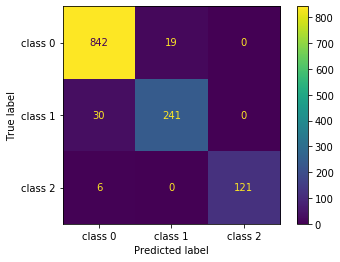

In [482]:
fit_predict_and_report(tuned_classifiers['xgboost'], X_train_scaled, X_test_scaled, y_train, y_test)

I've found 54 rows that appear both in the test set and the resampled set
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       861
           1       0.95      0.96      0.96       271
           2       1.00      0.95      0.98       127

    accuracy                           0.98      1259
   macro avg       0.98      0.97      0.97      1259
weighted avg       0.98      0.98      0.98      1259



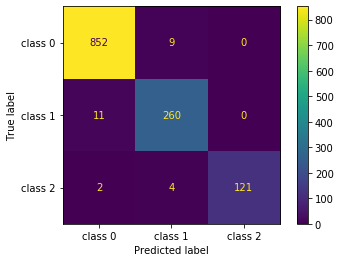

In [484]:
#Now construct an oversampled train set, but make sure I remove from the (oversampled) train set the samples existing in the test set
all_oversampled_rows = np.concatenate((X_problematic_1_resampled, X_problematic_0_resampled))
all_oversampled_ys = np.concatenate((y_problematic_1_resampled, y_problematic_0_resampled))

# problematic_indices_in_test_set = set(all_problematic_indices).intersection(inds_test)
# problematic_rows = X_test_scaled[np.array(problematic_indices_in_test_set)]
inds_to_delete = []
for i,r in enumerate(all_oversampled_rows):
    for rr in X_test:
        if all(r == rr):
            inds_to_delete.append(i)
print(f"I've found {len(inds_to_delete)} rows that appear both in the test set and the resampled set")
all_oversampled_rows_clean = np.delete(all_oversampled_rows, inds_to_delete, 0)
all_oversampled_ys_clean = np.delete(all_oversampled_ys, inds_to_delete, 0)
X_train_oversampled, y_train_oversampled = np.concatenate((X_train, all_oversampled_rows_clean)), np.concatenate((y_train, all_oversampled_ys_clean)) 
#Verify there is no intersection between the oversampled train to the test set.
for i,r in enumerate(X_train_oversampled):
    for rr in X_test:
        if all(r==rr):
            print(f"!!!! The row {r} is both in the train set and in the test set!!")
X_train_oversampled_scaled = scaler.transform(X_train_oversampled)

fit_predict_and_report(tuned_classifiers['xgboost'], X_train_oversampled_scaled, X_test_scaled , y_train_oversampled, y_test)


In [351]:
#This generates the full X oversampled.

X_oversampled, y_oversampled = np.delete(X, all_problematic_indices, 0),  np.delete(y, all_problematic_indices, 0)
X_oversampled = np.concatenate((X_oversampled, X_problematic_1_resampled, X_problematic_0_resampled))
y_oversampled = np.concatenate((y_oversampled, y_problematic_1_resampled, y_problematic_0_resampled))
X_oversampled_scaled = scaler_all.transform(X_oversampled)
#TODO: maybe np.random.shuffle?


True

In [ ]:
#Implement a function to be used in GridSearchCV, such that it's oversampling only the train set, and not the cross validation test.
class MyOversamplingTransformer:
    fit and transform methods
    
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

### Find optimal meta parameters ###

In [471]:
class ClassifierContainer:
    # Long_params_list - a wide range to examine.
    # short_params_list - reduced one based on wide range examination (to reduce runtime when executing)
    # short_params_list_over_entire_train - used for sanity tests over the entire train set.
    def __init__(self, clf, long_params_list, short_params_list, short_params_list_over_entire_train):
        self.clf = clf
        self.long_params_list = long_params_list
        self.short_params_list = short_params_list
        self.short_params_list_over_entire_train = short_params_list_over_entire_train
        

        
classifiers_dict = {
    'svm': ClassifierContainer(SVC(),
                    [{'kernel': ['rbf'], 'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30],
                     'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 700, 800, 1000, 1200, 1500]},
                    {'kernel': ['linear'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]}
                    ], 
                    [{'kernel': ['rbf'], 'gamma': [ 1],
                     'C': [300, 500, 700, 1000]}
                    ], 
                    [{'kernel': ['rbf'], 'gamma': [ 0.03 ],
                     'C': [300, 500]}
                    ]
            ), 
                            
    'random_forest' : ClassifierContainer(RandomForestClassifier(), 
                           [{ 'n_estimators' : [100, 200, 500, 1000, 1200, 1500],
                              'max_depth': [ 10, 20, 30, 40, 50, 60, 100], 
                              'class_weight' :['balanced'] }
                           ], 
                            [{ 'n_estimators' : [ 500, 600],
                              'max_depth': [ 30, 40 ], 
                              'class_weight' :['balanced'] }
                           ], 
                            [{ 'n_estimators' : [ 1000, 1200],
                              'max_depth': [ 60 ], 
                              'class_weight' :['balanced'] }
                           ]
                    ),
    
    'xgboost' : ClassifierContainer( xgb.XGBClassifier(), 
                           [{ 'reg_lambda' : [10, 30, 100, 300], #[0.1, 0.3, 1, 3, 10, 30, 100, 300],
                              'max_depth': [5, 7, 10, 20, 30], #[ 10, 20, 30, 40, 50, 60, 100], 
                              'n_estimators' : [ 1000, 1500, 2000, 2500],
                              'n_jobs' : [6]
                               }
                           ], 
                             [{ 'reg_lambda' : [ 10 ],
                                'max_depth': [ 20], 
                               'n_jobs' : [6], 
                               'n_estimators' :[1500]
                               }
                           ], 
                             [{ 'reg_lambda' : [ 30 ],
                                'max_depth': [ 20], 
                               'n_jobs' : [6]
                               }
                           ]
                    ), 
    'nn'   : ClassifierContainer( MLPClassifier(), 
                           [{ 'hidden_layer_sizes' : [(100, 15), (500, 150), (1000, 300), (3500, 700)], 
                              'alpha' : [0.00001, 0.00003, 0.001, 0.003, 0.1, 0.3, 1, 3, 10, 30, 100, 300]
                               }
                           ], 
                             [{ 'hidden_layer_sizes' : [(1000, 300)], 
                              'alpha' : [ 0.003]
                               }
                           ], 
                             [{ 'hidden_layer_sizes' : [(1000, 300)], 
                              'alpha' : [ 0.003]
                               }
                           ]
                    )
         
}





classifiers_dict_smote_pipeline = {
    'svm': ClassifierContainer(Pipeline(steps =  [('over', SMOTE()), ('under', RandomUnderSampler() ), ('model',  SVC())]) ,
                    [{
                        'over__sampling_strategy': [{1:1267}, {1:1167}, {1:1367} ],
                        'under__sampling_strategy': [{0:2438}, {0:2338}, {0:2538} ],
                        'model__kernel': ['rbf'], 
                        'model__gamma': [0.01, 0.03, 0.1],
                        'model__C': [ 300, 700, 800]
                     },                    
                    ], 
                    [{'kernel': ['rbf'], 'gamma': [ 1],
                     'C': [300, 500, 700, 1000]}
                    ], 
                    [{'kernel': ['rbf'], 'gamma': [ 0.03 ],
                     'C': [300, 500]}
                    ]
            ), 
                            
#     'random_forest' : ClassifierContainer(RandomForestClassifier(), 
#                            [{ 'n_estimators' : [100, 200, 500, 1000, 1200, 1500],
#                               'max_depth': [ 10, 20, 30, 40, 50, 60, 100], 
#                               'class_weight' :['balanced'] }
#                            ], 
#                             [{ 'n_estimators' : [ 500, 600],
#                               'max_depth': [ 30, 40 ], 
#                               'class_weight' :['balanced'] }
#                            ], 
#                             [{ 'n_estimators' : [ 1000, 1200],
#                               'max_depth': [ 60 ], 
#                               'class_weight' :['balanced'] }
#                            ]
#                     ),
    
    'xgboost' : ClassifierContainer(Pipeline(steps =  [('over', SMOTE()), ('model',  xgb.XGBClassifier())]), 
                       [{
                            'over__sampling_strategy': [None, {1:1267}, {1:1167}, {1:1367} ],
                            'under__sampling_strategy': [{0:2438}, {0:2338}, {0:2538} ],
                            'model__reg_lambda' : [5, 10, ], #[0.1, 0.3, 1, 3, 10, 30, 100, 300],
                            'model__max_depth': [ 7, 10, 20, 30], #[ 10, 20, 30, 40, 50, 60, 100], 
                            'model__n_estimators' : [ 1000, 1500, 2000, 2500],
#                             'model__sample_weight':[None, weights_array],
                            'model__n_jobs' : [6]
                    
                         },                    
                        ], 
                       [{
                        'over__sampling_strategy': [None, {1:1267}, {1:1167}, {1:1367} ],
#                         'under__sampling_strategy': [{0:2438}, {0:2338}, {0:2538} ],
                        'model__reg_lambda' : [10, ], #[0.1, 0.3, 1, 3, 10, 30, 100, 300],
                        'model__max_depth': [ 20], #[ 10, 20, 30, 40, 50, 60, 100], 
                        'model__n_estimators' : [ 2000],
                        'model__n_jobs' : [6]

                         },                    
                        ], 
                        [{ 'reg_lambda' : [ 30 ],
                            'max_depth': [ 20], 
                           'n_jobs' : [6]
                           }
                       ]
                    ), 
    'nn'   : ClassifierContainer( MLPClassifier(), 
                           [{ 'hidden_layer_sizes' : [(100, 15), (500, 150), (1000, 300)], 
                              'alpha' : [0.00001, 0.00003, 0.001, 0.003, 0.1, 0.3, 1, 3, 10, 30, 100, 300]
                               }
                           ], 
                             [{ 'hidden_layer_sizes' : [(1000, 300)], 
                              'alpha' : [ 0.003]
                               }
                           ], 
                             [{ 'hidden_layer_sizes' : [(1000, 300)], 
                              'alpha' : [ 0.003]
                               }
                           ]
                    )
    

    
         
}

In [134]:
# (1.5987210231814548, 0.8612873980054397)
CV_train_set_size = 4*len(X_train)/5
print(f"In cv train set, the classes numbers will be: 0: {CV_test_set_size*0.7027}, 1: {CV_test_set_size*0.1968}, 2: {CV_test_set_size*0.1005}   ")
print(f"therefore, in the over and undersampling, the numbers should be around: 0: {0.86128*CV_test_set_size*0.7027}, 1: {1.598*CV_test_set_size*0.1968}")

In cv train set, the classes numbers will be: 0: 2830.4755999999998, 1: 792.7104, 2: 404.814   
therefore, in the over and undersampling, the numbers should be around: 0: 2437.8320247680003, 1: 1266.7512192000002


In [127]:
print_classes_proportions(y_train)

Classes proportions in given set: 0: 70.27%, 1: 19.68%, 2: 10.05%


In [469]:
def my_custom_loss_func(y_true, y_pred):
    return sklearn.metrics.f1_score(y_true, y_pred, average=None).min()

score_min_f1 = make_scorer(my_custom_loss_func, greater_is_better=True)
    
def find_optimal_meta_parameters(train_x, train_y, classifier, tuned_parameters_dict, score='f1'):
   


    scores = [score]
    for score in scores:
        print("# Tuning hyper-parameters for %s" % "min_f1")
        print()
#         cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
        cv = StratifiedKFold(n_splits=5)
        clf = GridSearchCV( #RandomizedSearchCV( # GridSearchCV(
            classifier, tuned_parameters_dict, scoring=score_min_f1,
            verbose=10, 
            n_jobs=6, cv =cv
        )
        clf.fit(train_x, train_y)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    return clf.best_estimator_


**Tunning the parameters**

In [508]:
# Tune each of the considered classifiers, and store the one with highest performance in tuned_classifiers
list_to_tune_options = ['long', 'short', 'short_on_all']
list_to_tune = 'long'
classifier_dict_to_use = classifiers_dict #classifiers_dict_smote_pipeline
tuned_classifiers = {}

train_X = X_scaled #X_train_scaled
train_y = y #y_train

for clfname in classifier_dict_to_use:
    if clfname != 'xgboost':
        continue
    print( "\n ############## Tuning meta parameters for classifier {} ########### \n".format(clfname))
    clf_params_to_tune = classifier_dict_to_use[clfname]
    if list_to_tune == 'long':
        params_to_tune = clf_params_to_tune.long_params_list
    elif list_to_tune == 'short':
        params_to_tune = clf_params_to_tune.short_params_list
    elif list_to_tune == 'short_on_all':
        params_to_tune = clf_params_to_tune.short_params_list_over_entire_train
    else:
        print("list_to_tune {} is not valid!".format(list_to_tune))
         
    curr_best_estimator = find_optimal_meta_parameters(train_X, train_y , clf_params_to_tune.clf, 
                                 params_to_tune ,
                                 score='f1')
    tuned_classifiers[clfname] = curr_best_estimator




 ############## Tuning meta parameters for classifier xgboost ########### 

# Tuning hyper-parameters for min_f1

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed: 14.7min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed: 29.1min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed: 33.1min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed: 38.4min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed: 45.5min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 54.0min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed: 61.8min
[Parallel(

Best parameters set found on development set:

{'max_depth': 20, 'n_estimators': 1000, 'n_jobs': 6, 'reg_lambda': 30}

Grid scores on development set:

0.894 (+/-0.027) for {'max_depth': 5, 'n_estimators': 1000, 'n_jobs': 6, 'reg_lambda': 10}
0.888 (+/-0.027) for {'max_depth': 5, 'n_estimators': 1000, 'n_jobs': 6, 'reg_lambda': 30}
0.889 (+/-0.024) for {'max_depth': 5, 'n_estimators': 1000, 'n_jobs': 6, 'reg_lambda': 100}
0.889 (+/-0.031) for {'max_depth': 5, 'n_estimators': 1000, 'n_jobs': 6, 'reg_lambda': 300}
0.891 (+/-0.029) for {'max_depth': 5, 'n_estimators': 1500, 'n_jobs': 6, 'reg_lambda': 10}
0.887 (+/-0.028) for {'max_depth': 5, 'n_estimators': 1500, 'n_jobs': 6, 'reg_lambda': 30}
0.889 (+/-0.029) for {'max_depth': 5, 'n_estimators': 1500, 'n_jobs': 6, 'reg_lambda': 100}
0.892 (+/-0.030) for {'max_depth': 5, 'n_estimators': 1500, 'n_jobs': 6, 'reg_lambda': 300}
0.891 (+/-0.030) for {'max_depth': 5, 'n_estimators': 2000, 'n_jobs': 6, 'reg_lambda': 10}
0.887 (+/-0.027) for {'ma

In [234]:
tuned_classifiers

{'svm': SVC(C=1500, gamma=0.01),
 'random_forest': RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=200),
 'xgboost': XGBClassifier(max_depth=20, n_estimators=1000, n_jobs=6,
               objective='multi:softprob', reg_lambda=300, sample_weight=None),
 'nn': MLPClassifier(alpha=1e-05, hidden_layer_sizes=(100, 15))}

In [511]:
len(X_train_scaled)

5035

In [ ]:
'''
best classifier for partial train: {'max_depth': 20, 'n_estimators': 1000, 'n_jobs': 6, 'reg_lambda': 30}
best classifier for full train:    {'max_depth': 20, 'n_estimators': 1000, 'n_jobs': 6, 'reg_lambda': 30}
'''

In [493]:
from sklearn.base import clone
tuned_classifiers_for_submission = {}
tuned_classifiers_for_submission['fitted_on_partial_train'] = 
    xgb.XGBClassifier(max_depth=20, n_estimators=1000, n_jobs=6, reg_lambda=30).fit(X_train_scaled, y_train)
tuned_classifiers_for_submission['fitted_on_all_train'] = tuned_classifiers['xgboost']
tuned_classifiers_for_submission['smote_fitted_on_partial_train'] =\
            clone(tuned_classifiers_for_submission['fitted_on_partial_train']).fit( X_train_oversampled_scaled, y_train_oversampled ) 
# tuned_classifiers_for_submission['smote_fitted_on_all_train'] = 
#             clone(tuned_classifiers_for_submission['fitted_on_partial_train']).fit(X_oversampled_scaled, y_oversampled_scaled) 


In [489]:
tuned_classifiers_for_submission

{'fitted_on_partial_train': XGBClassifier(max_depth=20, n_estimators=1000, n_jobs=6,
               objective='multi:softprob', reg_lambda=30),
 'fitted_on_all_train': XGBClassifier(max_depth=20, n_estimators=1000, n_jobs=6,
               objective='multi:softprob', reg_lambda=30),
 'smote_fitted_on_partial_train': XGBClassifier(max_depth=20, n_estimators=1000, n_jobs=6,
               objective='multi:softprob', reg_lambda=30)}

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       861
           1       0.95      0.96      0.96       271
           2       1.00      0.95      0.98       127

    accuracy                           0.98      1259
   macro avg       0.98      0.97      0.97      1259
weighted avg       0.98      0.98      0.98      1259



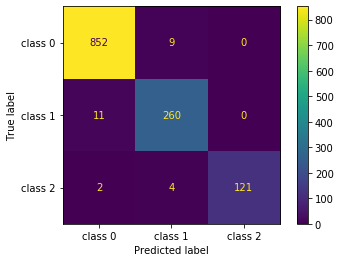

In [499]:
# fit_predict_and_report(tuned_classifiers_for_submission['fitted_on_partial_train'], X_train_scaled, X_test_scaled, y_train, y_test)
fit_predict_and_report(tuned_classifiers_for_submission['smote_fitted_on_partial_train'], X_train_oversampled_scaled, X_test_scaled , y_train_oversampled, y_test)

In [500]:
def plot_features_importances(importances):
    plt.figure(figsize=(12, 3))
    plt.title("Feature importances")
    indices = np.argsort(importances)[::-1]
    plt.bar(range(len(importances)), importances[indices],
            color="r",align="center")
    plt.xticks(range(len(importances)), np.array(features_names)[indices], rotation='vertical')
    plt.xlim([-1, len(importances)])
    plt.show()



################# cassification report for classifier xgboost ################

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       861
           1       0.93      0.89      0.91       271
           2       1.00      0.95      0.98       127

    accuracy                           0.96      1259
   macro avg       0.96      0.94      0.95      1259
weighted avg       0.96      0.96      0.96      1259


 Confusion matrix (Wikipedia format):

[[842  30   6]
 [ 19 241   0]
 [  0   0 121]]

 Confusion matrix (sklearn (transposed) format):



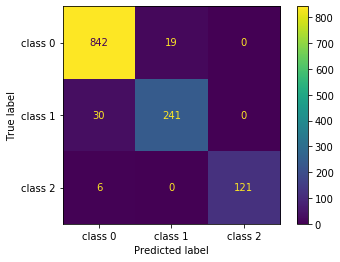

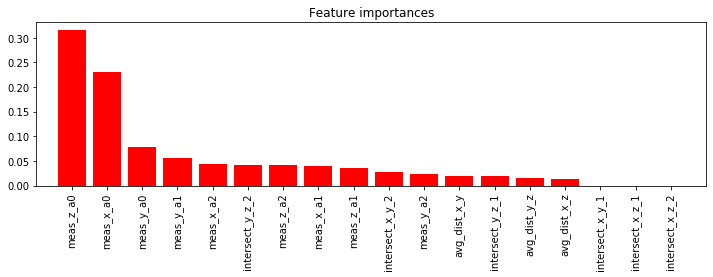


##################################################################################

The classifier with the maximal minimal f1 score is xgboost


In [475]:
#Summarize the performance of each of the tuned classifiers, and find the one with max-min F1 score.

min_f1 = {}
curr_figsize = plt.rcParams['figure.figsize']
for clfname in tuned_classifiers:
    print()
    print( "\n################# cassification report for classifier {} ################\n".format(clfname))
    clf = tuned_classifiers[clfname]
    y_true, y_pred = y_test, clf.predict(X_test_scaled)
    print( classification_report(y_true, y_pred) )
    print("\n Confusion matrix (Wikipedia format):\n")
    print(confusion_matrix(y_true, y_pred, labels=[0,1,2]).T) 
    print("\n Confusion matrix (sklearn (transposed) format):\n")
    plot_confusion_matrix(clf, X_test_scaled, y_true, display_labels=['class 0', 'class 1', 'class 2'], values_format='.0f')
    plt.show()
    if hasattr(clf, 'feature_importances_'):
        plot_features_importances( clf.feature_importances_)
    else:
        print("Can't produce feature importance for classifier {}".format(clfname))
        
    min_f1[clfname] = np.min(f1_score(y_true, y_pred, average=None))
    print("\n##################################################################################\n")
    
sorted_clfnames_by_scores = [k for k, v in sorted(min_f1.items(), key=lambda item: item[1])]
best_classifier = tuned_classifiers[sorted_clfnames_by_scores[-1]]
print("The classifier with the maximal minimal f1 score is {}".format(sorted_clfnames_by_scores[-1]))

# Submission


**Use the best classifier to predict over the given train set.**

Here are the files I want to submit:

- 18 features, xgb classifier - train-test split, and over all train.
- SMOTE - train-test split + tuning, and over all train.
- Optional - SMOTE w.r.t. zeros and 1s 


In [501]:
X_test_for_submission,_,_  = extract_features(test_set_df, ts_handling_scheme='create_x')
scaler_submission = preprocessing.StandardScaler().fit(X)
X_scaled = scaler_submission.transform(X)
X_test_for_submission_scaled = scaler_submission.transform(X_test_for_submission)

In [503]:
def predict_and_save_to_file(clf, clf_id):
    y_test_predicted = clf.predict(X_test_for_submission_scaled)
    res_df = pd.DataFrame( { 'label' : y_test_predicted, 'patient_id' : test_set_df.groupby('patient_id').nth(0).index.values})
    res_df.to_csv(f"submission_{clf_id}.csv", index=False)


In [504]:
# Now apply on provided test set.
for clf_id, clf in tuned_classifiers_for_submission.items():
    predict_and_save_to_file(clf, clf_id)

In [506]:
pwd

'C:\\workspace\\ML\\ClewMedical'

## Problematic points handling trial  ##
There's a set of about 200 points which are misclassfied between 0 and 1. I'll try the following: 
1. What happens if I put all of them in the training set?
2. What happens if I oversample this particular subset, and add it to the overall dataset?



In [245]:
class1_classification_dict['fn0']

[(2426, 9912),
 (4655, 18998),
 (795, 3252),
 (4555, 18597),
 (1296, 5283),
 (4737, 19323),
 (743, 3038),
 (771, 3155),
 (3206, 13103),
 (3906, 15962),
 (4229, 17279),
 (528, 2160),
 (535, 2187),
 (3524, 14390),
 (2608, 10676),
 (357, 1462),
 (3688, 15078),
 (2991, 12238),
 (4152, 16971),
 (6116, 24980),
 (5728, 23388),
 (2230, 9108),
 (2150, 8775),
 (4674, 19068),
 (3782, 15457),
 (4020, 16435),
 (293, 1189),
 (1730, 7082),
 (2357, 9630),
 (1557, 6374),
 (5434, 22188),
 (5711, 23318),
 (5410, 22093),
 (5133, 20947),
 (3129, 12791),
 (2075, 8477),
 (2764, 11310),
 (4206, 17189),
 (2926, 11972),
 (102, 414),
 (3573, 14591),
 (541, 2210),
 (2917, 11936),
 (6241, 25483),
 (334, 1367),
 (4926, 20109),
 (5529, 22577),
 (976, 3967),
 (2952, 12084),
 (4288, 17510),
 (1695, 6936),
 (2351, 9604),
 (828, 3386),
 (3271, 13362),
 (1693, 6926),
 (5200, 21230),
 (1831, 7484),
 (5109, 20849),
 (4681, 19096),
 (1963, 8019),
 (268, 1091),
 (5897, 24069),
 (4030, 16475),
 (4276, 17460),
 (3769, 15406),


**1. Construct a train set containing all these datapoints.**

In [324]:
#Swap indices so that all problematic ones are in the train set. Make sure the class proportion remains the same 
#, that is: swap ones with ones
def swap_indices(problematic_indices, zero_or_one, train_index, test_index, y):
    problematic_in_test = set(test_index).intersection(problematic_indices)
    non_problematic_in_train = list(set(train_index).difference(problematic_indices))
    non_problematic_in_train = np.where(y[non_problematic_in_train]==zero_or_one)[0]
    non_problematic_to_swap = non_problematic_in_train[np.random.randint(0, len(non_problematic_in_train),
                                                                         len(problematic_in_test) )]
    indices_train_updated = list(set(train_index).difference(non_problematic_to_swap).union(problematic_in_test))
    indices_test_updated = list(set(test_index).difference(problematic_indices).union(non_problematic_to_swap))
    return indices_train_updated, indices_test_updated
   
    

def force_problematic_to_train(problematic_indices_ones, problematic_indices_zeros, train_index, test_index,  y):
    print("########### Before forcing index ###########")
    print( f"There are {len(problematic_indices_ones)} problematic 1 indices, and\
    {len(problematic_indices_zeros)} problematic 0 indices")
    
    train_index_fixed_ones, test_index_fixed_ones = swap_indices(problematic_indices_ones, 1, train_index, test_index, y)
    train_index_fixed, test_index_fixed = swap_indices(problematic_indices_zeros, 0, train_index_fixed_ones, test_index_fixed_ones, y)
    print("########### After forcing index ###########")
    print(f"There are {len(set(train_index_fixed).intersection(problematic_indices_zeros))} zeros out of {len(problematic_indices_zeros)} in the train set") 
    print(f"There are {len(set(train_index_fixed).intersection(problematic_indices_ones))} ones out of {len(problematic_indices_ones)} in the train set") 
    print(f"There are {len(set(test_index_fixed).intersection(problematic_indices_zeros))} zeros out of {len(problematic_indices_zeros)} in the test set") 
    print(f"There are {len(set(test_index_fixed).intersection(problematic_indices_ones))} ones out of {len(problematic_indices_ones)} in the test set") 

    return train_index_fixed, test_index_fixed
    

    
    


X_train_forced, X_test_forced, y_train_forced, y_test_forced, inds_train_forced, inds_test_forced = train_test_split(X, y, np.arange(len(y)), test_size = 0.2)
scaler = preprocessing.StandardScaler().fit(X_train_forced)
X_train_scaled_forced = scaler.transform(X_train_forced)
X_test_scaled_forced = scaler.transform(X_test_forced)





cv = StratifiedKFold(n_splits = 5, shuffle=True)
for train_index, test_index in cv.split(X_scaled, y):
    print("#################")
    print(f"Before forcing.")
    print_classes_proportions(y_train_cv)
    print_classes_proportions(y_test_cv)    
    train_index_forced, test_index_forced = force_problematic_to_train(problematic_indices_ones,
                                                                    problematic_indices_zeros, train_index,
                                                                    test_index, y)
    X_train_cv_forced, X_test_cv_forced = X[train_index_forced], X[test_index_forced]
    y_train_cv_forced, y_test_cv_forced = y[train_index_forced], y[test_index_forced]
    print(f"After forcing.")
    print_classes_proportions(y_train_cv_forced)
    print_classes_proportions(y_test_cv_forced)    

    y_true_cv_forced, y_pred_cv_forced = y_test_cv_forced, tuned_classifiers['xgboost'].fit(X_train_cv_forced, y_train_cv_forced).predict(X_test_cv_forced)
    print( classification_report(y_true_cv_forced, y_pred_cv_forced) )




#################
Before forcing.
Classes proportions in given set: 0: 70.10%, 1: 19.88%, 2: 10.03%
Classes proportions in given set: 0: 70.11%, 1: 19.87%, 2: 10.02%
########### Before forcing index ###########
There are 135 problematic 1 indices, and    107 problematic 0 indices
########### After forcing index ###########
There are 107 zeros out of 107 in the train set
There are 135 ones out of 135 in the train set
There are 0 zeros out of 107 in the test set
There are 0 ones out of 135 in the test set
After forcing.
Classes proportions in given set: 0: 69.85%, 1: 20.21%, 2: 9.94%
Classes proportions in given set: 0: 71.11%, 1: 18.52%, 2: 10.38%
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       891
           1       0.97      0.95      0.96       232
           2       0.97      0.95      0.96       130

    accuracy                           0.98      1253
   macro avg       0.98      0.97      0.97      1253
weighted avg       

KeyboardInterrupt: 

**This worked well, which meanse once the problematic points are trained on, prediction is very accurate. Now, if I use the entire train set, they will all be included anyhow. But there will probably be others which won't. So what I'll try now is 
just to oversample this specific problematic set.**

In [434]:
len(set(all_problematic_indices).intersection(inds_test))

54

In [399]:
len(all_oversampled_rows)

882

In [405]:
for i,r in enumerate(all_oversampled_rows[1,:]):
    if all_oversampled_rows[0,:] == r:
        print(i)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [392]:
print(set(all_problematic_indices).intersection(inds_test))
X[1153,:] in X_test

{1153, 771, 5127, 2057, 268, 4621, 3729, 3220, 1557, 2964, 5401, 2853, 2730, 2991, 177, 2994, 437, 2614, 5687, 5830, 5577, 1994, 4555, 5962, 970, 3280, 4053, 85, 4442, 4189, 6241, 4066, 356, 2917, 3691, 1387, 3821, 4847, 5623, 632, 3066, 4476, 4734}


True

In [366]:
## THis is not good, since prediction is over an oversampled test set. Should be over the original test set.

X_train_oversampled, X_test_oversampled, y_train_oversampled, y_test_oversampled, inds_train_oversampled, inds_test_oversampled =\
    train_test_split(X_oversampled, y_oversampled, np.arange(len(y_oversampled)), test_size = 0.2)
scaler = preprocessing.StandardScaler().fit(X_train_oversampled)
X_train_scaled_oversampled = scaler.transform(X_train_oversampled)
X_test_scaled_oversampled = scaler.transform(X_test_oversampled)
tuned_classifier.fit(X_train_scaled_oversampled, y_train_oversampled)
y_pred_oversampled = tuned_classifier.predict(X_test_scaled_oversampled)


              precision    recall  f1-score   support

           0       0.95      0.98      0.97       928
           1       0.93      0.86      0.90       325
           2       0.98      0.97      0.97       134

    accuracy                           0.95      1387
   macro avg       0.95      0.94      0.95      1387
weighted avg       0.95      0.95      0.95      1387



In [361]:
X_train_oversampled.shape

(5547, 18)

In [354]:
tuned_classifier


XGBClassifier(max_depth=20, n_estimators=1500, n_jobs=6,
              objective='multi:softprob', reg_lambda=10)

In [304]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
X, y = make_classification(n_classes=2, class_sep=2,
weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
n_features=20, n_clusters_per_class=1, n_samples=100, random_state=10)
print('Original dataset shape %s' % Counter(y))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))


Original dataset shape Counter({1: 90, 0: 10})
Resampled dataset shape Counter({1: 90, 0: 90})


In [307]:
X[y==0][2] in X_res

True

In [311]:
X_res[y_res==0][0] in X_res[y_res==0][1:,:]

False

In [318]:
np.concatenate((np.array([[1,2,3], [4,5,6]]), np.array([[7,8,9]])))

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [377]:

XX = np.array([[1,2],[3,4], [5,6], [7,8], [9,10]])
 
XX_del = np.delete(XX, [2,4], 0)
XX_del

array([[1, 2],
       [3, 4],
       [7, 8]])

In [353]:
print(XX)
np.random.shuffle(XX)
print(XX)

[[ 5  6]
 [ 7  8]
 [ 1  2]
 [ 9 10]
 [ 3  4]]
[[ 1  2]
 [ 5  6]
 [ 3  4]
 [ 7  8]
 [ 9 10]]


In [409]:
[11,6] in XX

True

In [412]:
sxx = set(list(XX))

TypeError: unhashable type: 'numpy.ndarray'

In [415]:
all(np.array([1,2,3]) == np.array([1,2,3]))

True

In [376]:
X_problematic_0_resampled[2,:] in X_problematic_0_resampled
np.where(  X_problematic_0_resampled == X_problematic_0_resampled[2,:])

(array([  0,   0,   0, ..., 440, 440, 440], dtype=int64),
 array([ 9, 10, 11, ..., 12, 13, 14], dtype=int64))

In [281]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler # doctest: +NORMALIZE_WHITESPACE
X, y = make_classification(n_classes=2, class_sep=2,
weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
n_features=20, n_clusters_per_class=1, n_samples=10, random_state=10)
print('Original dataset shape %s' % Counter(y))

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 9, 0: 1})
Resampled dataset shape Counter({1: 9, 0: 9})


In [284]:
X_res[y_res==0][0] == X_res[y_res==0][4]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [389]:
from numpy.random import *
def plot_rand_samples(inds_list, n_samples, title ):
    inds_to_plot = np.random.randint(0, len(inds_list), n_samples)
    fig_1, axs_tp = plt.subplots((n_samples+1)//2, 2)
    fig_1.set_size_inches(22, 20)
    axs_tp_flattend = axs_tp.flatten()
    ax_ind = 0
    for ind_in_unique, ind_in_orig in np.array(inds_list)[inds_to_plot]:
        plot_patient_lines( ind_in_orig, extracted_features = X[ind_in_unique], plot_ax = axs_tp_flattend[ax_ind])
        ax_ind+=1
#     plot_patient_lines(X_test_tp_class_1_orig_inds[31], extracted_features = X_test_tp_class_1[31], plot_ax = axs_tp[0,1])
#     plot_patient_lines(X_test_tp_class_1_orig_inds[92], extracted_features = X_test_tp_class_1[92], plot_ax = axs_tp[1,0])
#     plot_patient_lines(X_test_tp_class_1_orig_inds[103], extracted_features = X_test_tp_class_1[103], plot_ax = axs_tp[1,1])
#     plot_patient_lines(X_test_tp_class_1_orig_inds[206], extracted_features = X_test_tp_class_1[206], plot_ax = axs_tp[2,0])
#     plot_patient_lines(X_test_tp_class_1_orig_inds[217], extracted_features = X_test_tp_class_1[217], plot_ax = axs_tp[2,1])
    
    fig_1.suptitle(title, size= 'xx-large', weight='extra bold');
    plt.tight_layout()

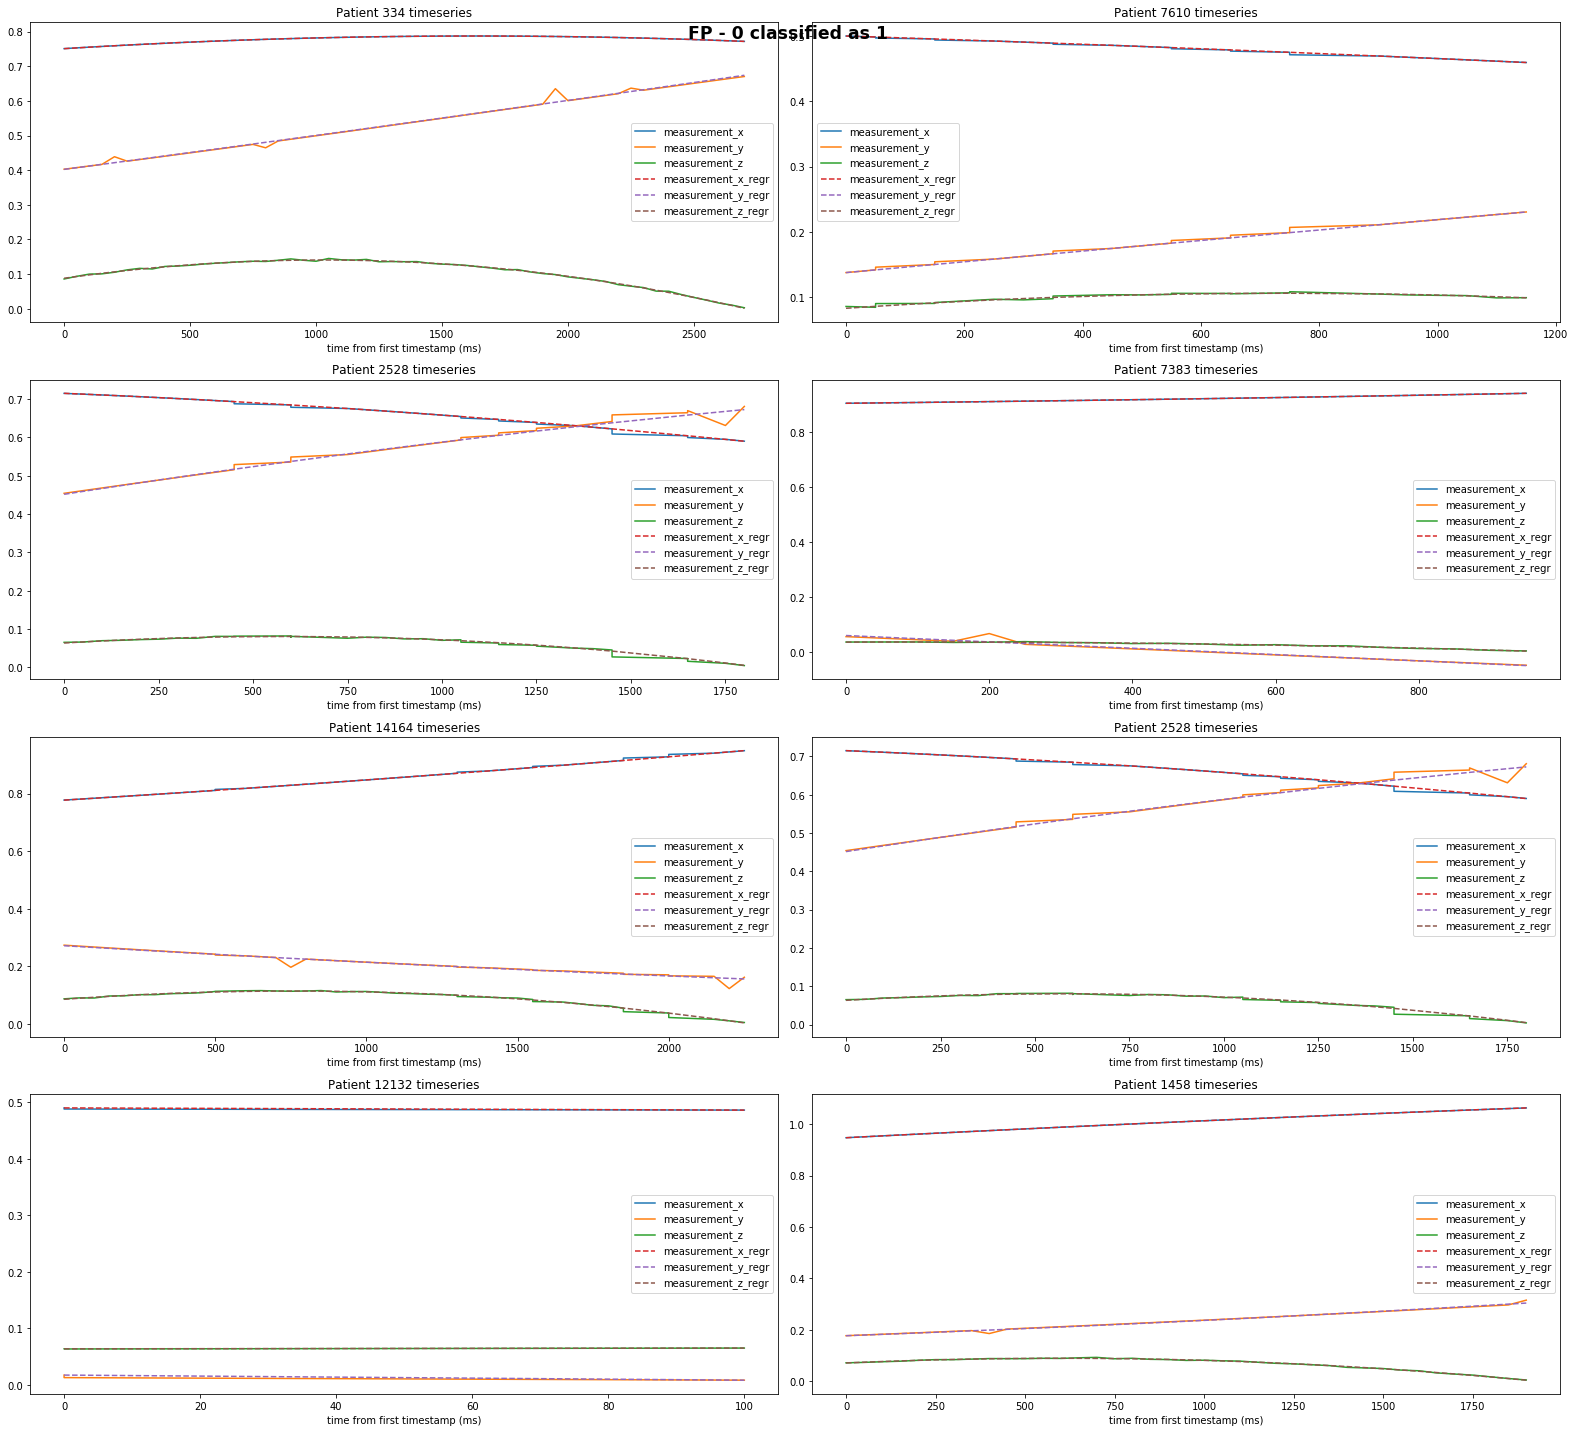

In [400]:
plot_rand_samples(class1_classification_dict['fp0'], 8, "FP - 0 classified as 1")

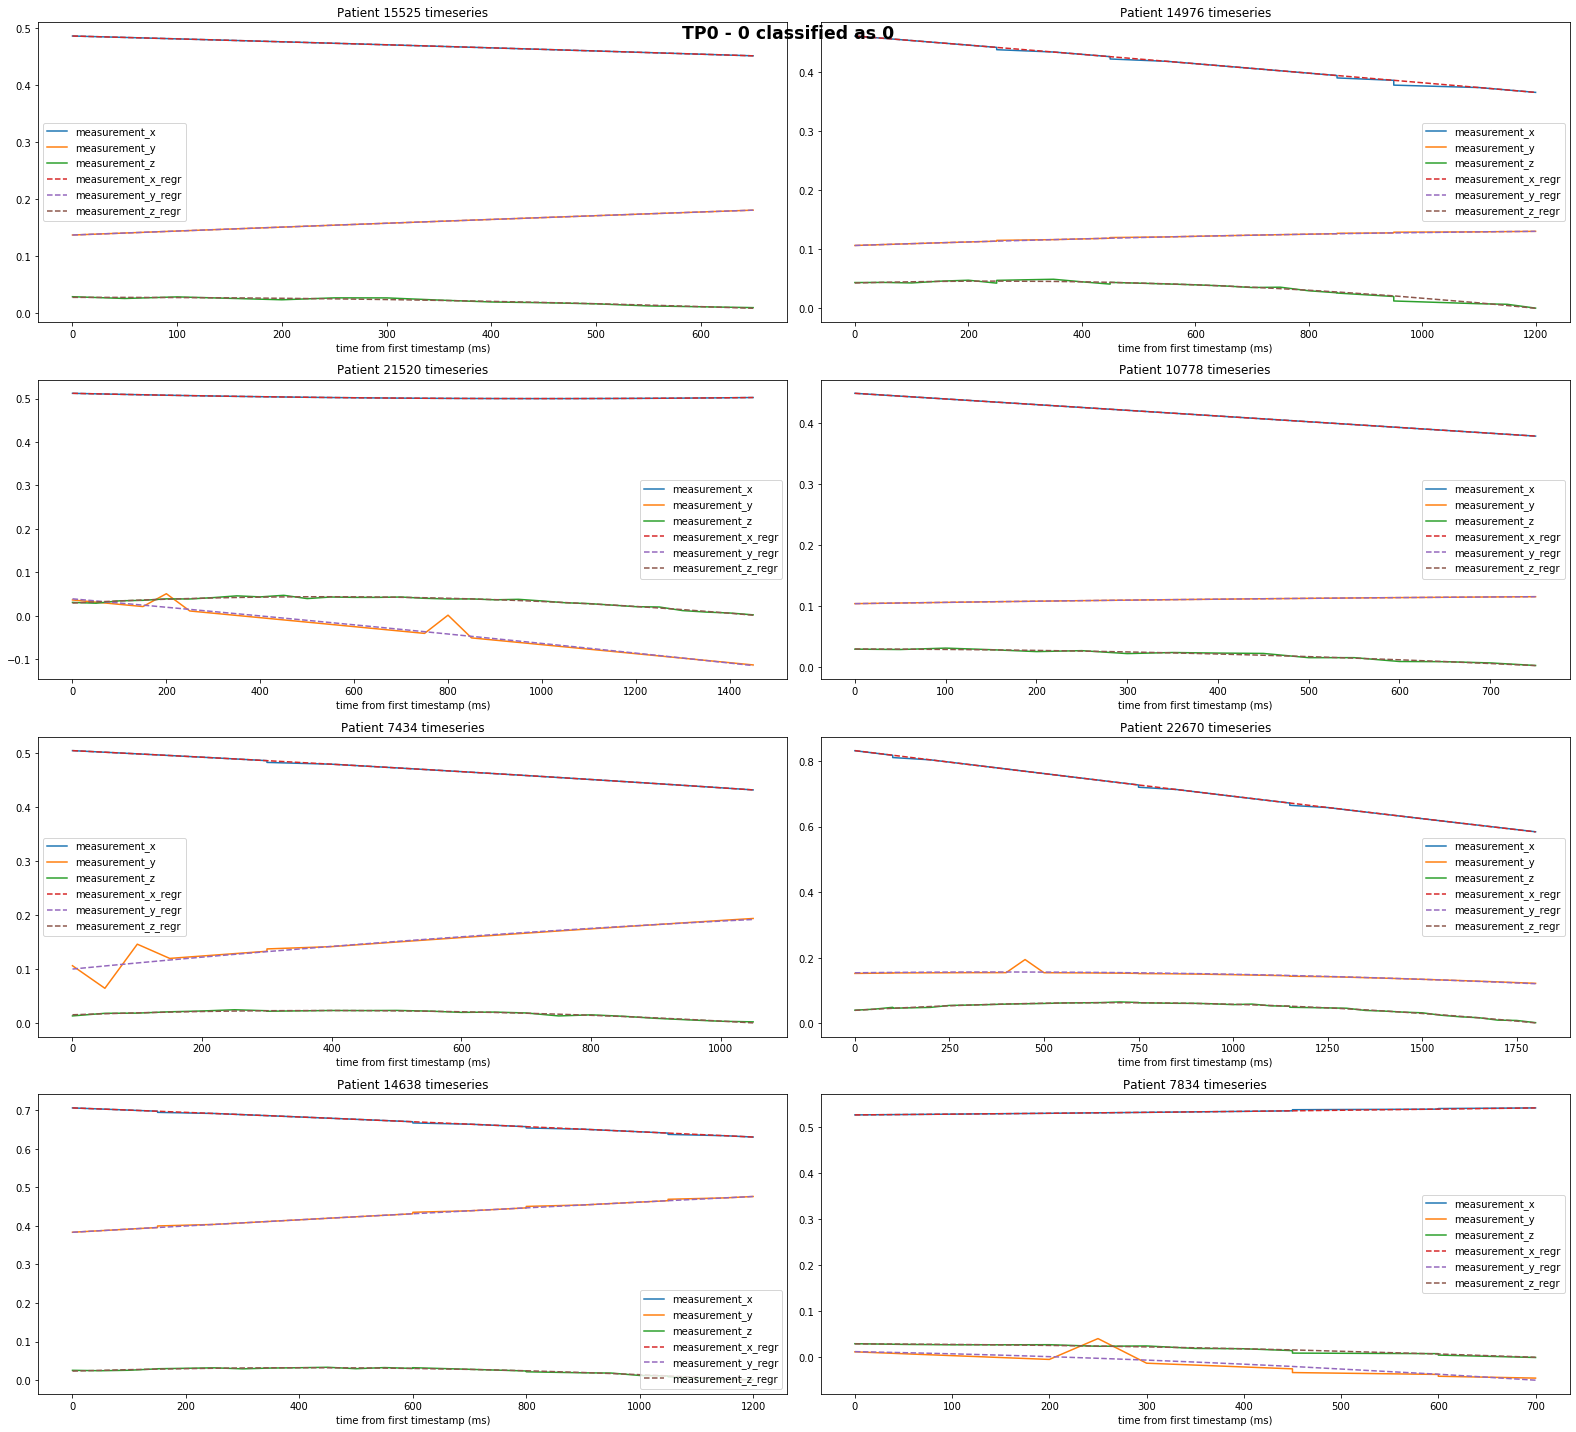

In [404]:
plot_rand_samples(class1_classification_dict['tp0'], 8, "TP0 - 0 classified as 0")

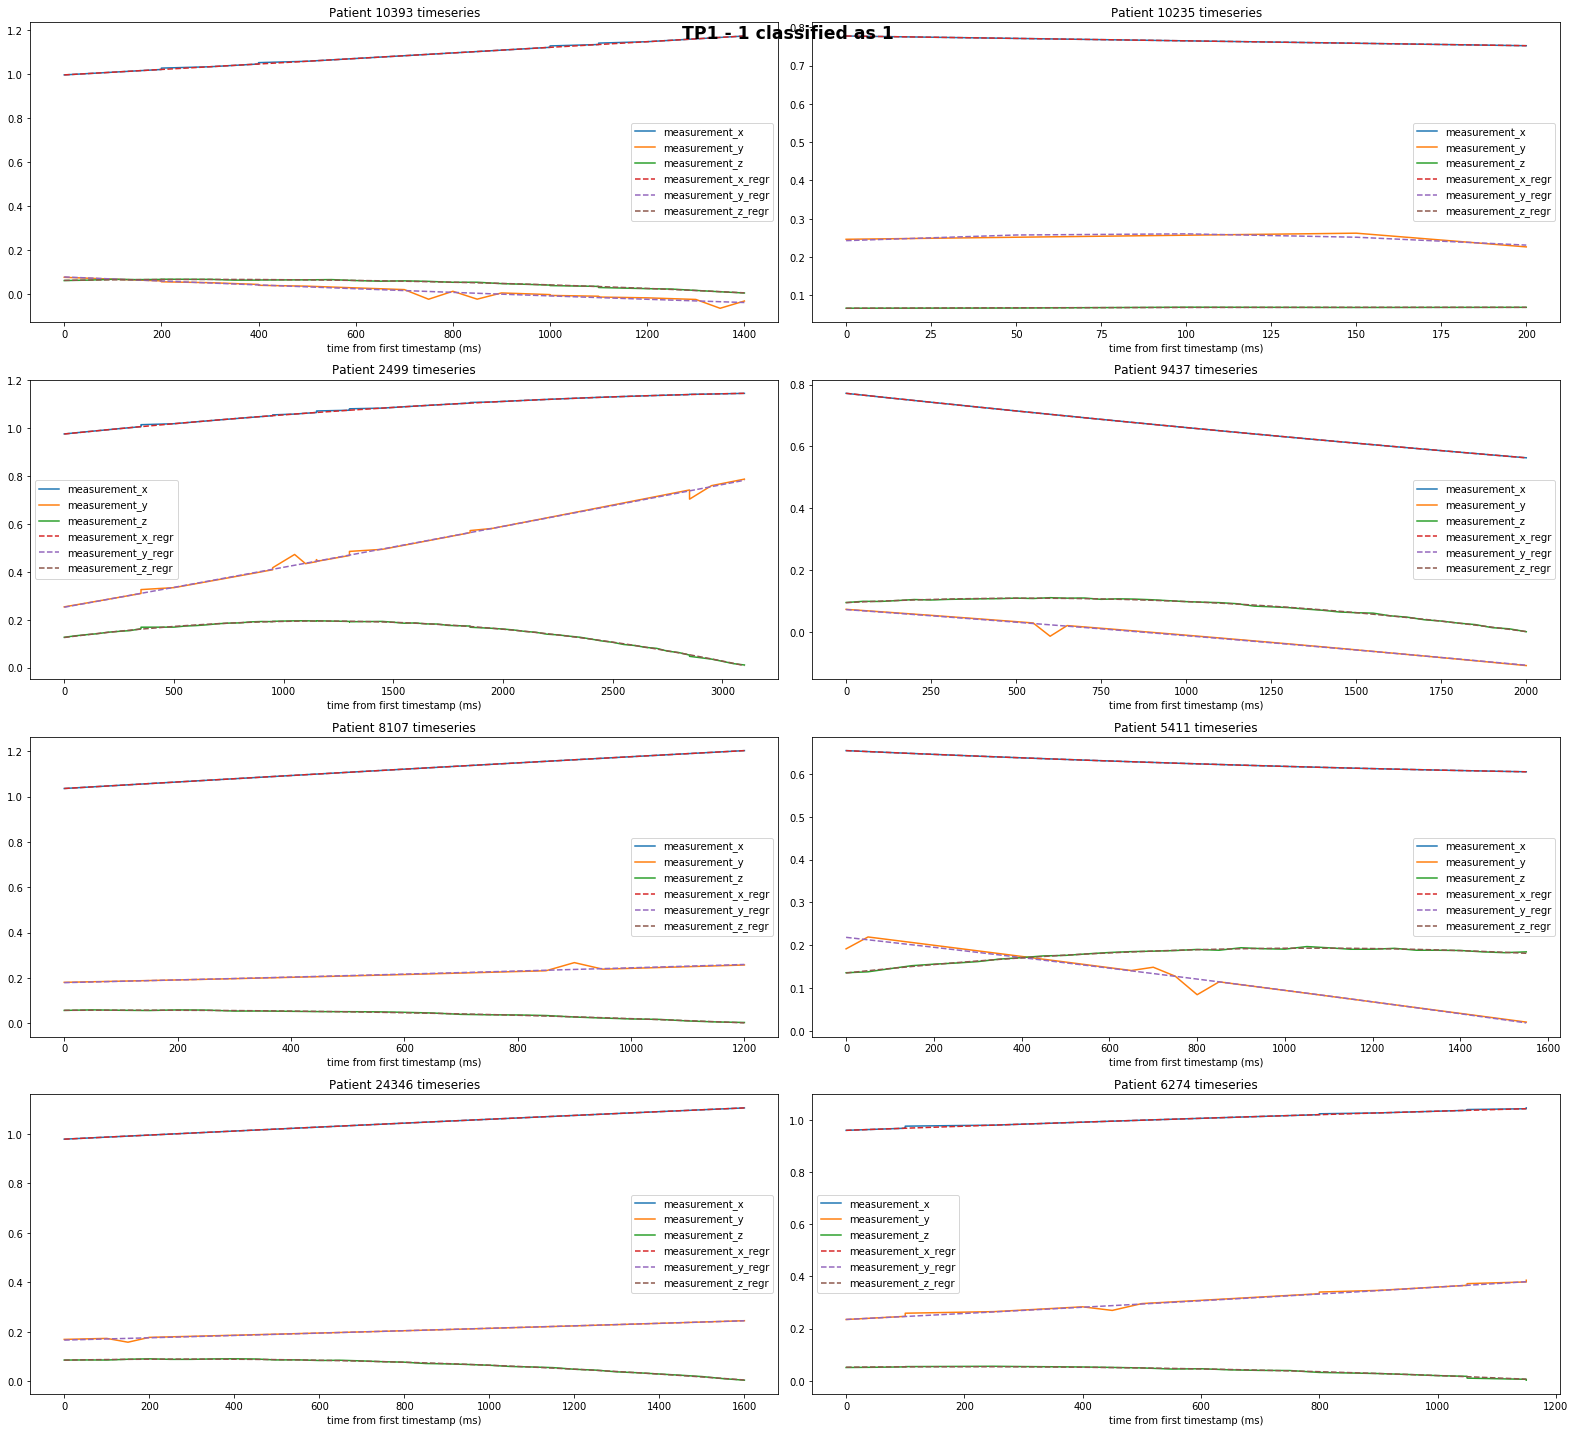

In [398]:
plot_rand_samples(class1_classification_dict['tp1'], 8, "TP1 - 1 classified as 1")

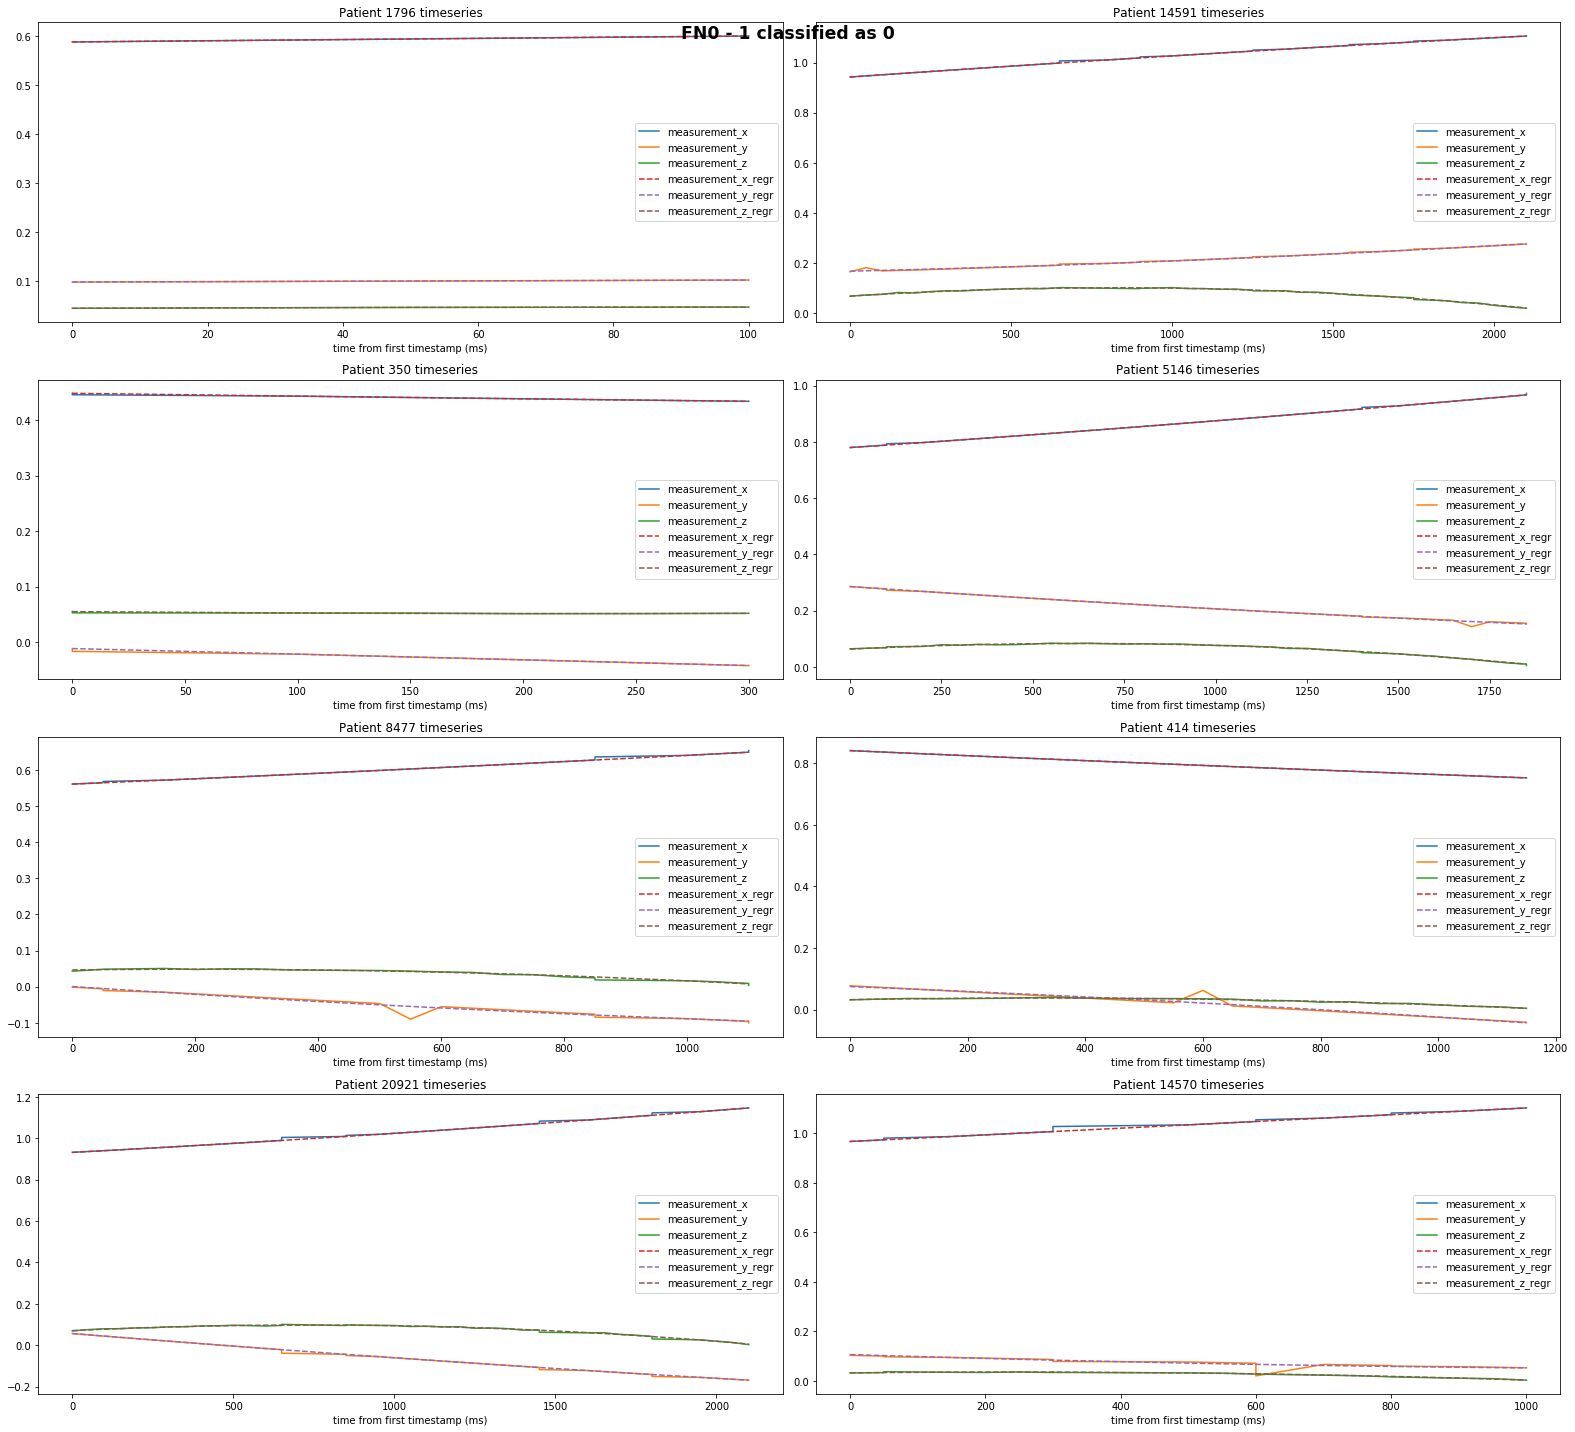

In [397]:
plot_rand_samples(class1_classification_dict['fn0'], 8, "FN0 - 1 classified as 0")

(48, <matplotlib.axes._subplots.AxesSubplot at 0x483d89b148>)

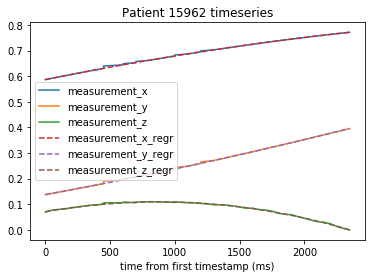

In [342]:


ind_in_unique, inds_in_orig = false_0_dict['fn'].pop()
train_set_grouped_by_patients.get_group(inds_in_orig)
plot_patient_lines(inds_in_orig, extracted_features = X[ind_in_unique])#, plot_ax = axs_tp[0,0])

In [77]:
# best_classifier =  xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#                colsample_bynode=1, colsample_bytree=1, gamma=0,
#                learning_rate=0.1, max_delta_step=0, max_depth=20,
#                min_child_weight=1, missing=None, n_estimators=1500, n_jobs=6,
#                nthread=None, objective='multi:softprob', random_state=0,
#                reg_alpha=0, reg_lambda=100, sample_weight=None,
#                scale_pos_weight=1, seed=None, silent=None, subsample=1,
#                verbosity=1)
# best_classifier.fit(X_train_scaled, y_train)
# tuned_classifiers['xgboost'] = best_classifier

## Examine specific estimator performance ##

In [290]:
tuned_classifiers['xgboost'].fit(X_train_scaled, y_train)
y_true, y_pred = y_test, tuned_classifiers['xgboost'].predict(X_test_scaled)
plot_confusion_matrix(best_classifier, X_test_scaled, y_true, display_labels=['class 0', 'class 1', 'class 2'], values_format='.0f')
plt.show()
print( classification_report(y_true, y_pred) )

KeyError: 'xgboost'

In [241]:
best_classifier == tuned_classifiers['xgboost']

True

In [42]:
weights_array_augment_1 = weights_array.copy()
weights_array_augment_1[y_train == 2] = weights_array[0]
weights_array_augment_1

array([0.47707031, 0.47707031, 0.47707031, ..., 0.47707031, 0.47707031,
       0.47707031])

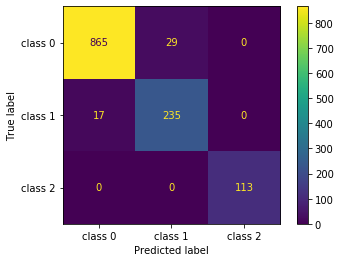

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       894
           1       0.89      0.93      0.91       252
           2       1.00      1.00      1.00       113

    accuracy                           0.96      1259
   macro avg       0.96      0.97      0.96      1259
weighted avg       0.96      0.96      0.96      1259



In [43]:

y_true, y_pred_weights = y_test, best_classifier.fit(X_train_scaled, y_train, sample_weight=weights_array_augment_1).predict(X_test_scaled)
plot_confusion_matrix(best_classifier, X_test_scaled, y_true, display_labels=['class 0', 'class 1', 'class 2'], values_format='.0f')
plt.show()
print( classification_report(y_true, y_pred_weights) )


In [252]:
 print( classification_report(y_true, y_pred_weights) )

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       874
           1       0.91      0.89      0.90       239
           2       0.99      0.96      0.98       146

    accuracy                           0.96      1259
   macro avg       0.96      0.94      0.95      1259
weighted avg       0.96      0.96      0.96      1259



In [65]:
 print( classification_report(y_true, y_pred) )

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       894
           1       0.91      0.92      0.92       252
           2       1.00      1.00      1.00       113

    accuracy                           0.97      1259
   macro avg       0.96      0.97      0.96      1259
weighted avg       0.97      0.97      0.97      1259



In [179]:
class_weight_dict = {0:1, 1:5, 2:1}
rf_classifier= tuned_classifiers['random_forest']
rf_classifier.class_weight = 'balanced' #class_weight_dict
rf_classifier

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [44]:

y_true, y_pred_rf_weights = y_test, tuned_classifiers['random_forest'].fit(X_train_scaled, y_train).predict(X_test_scaled)
plot_confusion_matrix(rf_classifier, X_test_scaled, y_true, display_labels=['class 0', 'class 1', 'class 2'], values_format='.0f')
plt.show()
print( classification_report(y_true, y_pred_rf_weights) )

KeyError: 'random_forest'

In [47]:
best_classifier

XGBClassifier(max_depth=20, n_estimators=1500, n_jobs=6,
              objective='multi:softprob', reg_lambda=10)

In [75]:
print(sum(y == 0))
print(sum(y == 1))
print(sum(y == 2))

4412
1251
631


In [132]:
oversamp_ratio = 2000/1251
undersamp_ratio = 3800/4412
print( (oversamp_ratio, undersamp_ratio))

(1.5987210231814548, 0.8612873980054397)


Pipeline(steps=[('over', SMOTE(sampling_strategy={1: 1267})),
                ('under', RandomUnderSampler(sampling_strategy={0: 2338})),
                ('model',
                 XGBClassifier(max_depth=20, n_estimators=1500, n_jobs=6,
                               objective='multi:softprob', reg_lambda=10))])

In [189]:
# !!! Bset so far!!! oversample = SMOTE(sampling_strategy={1:2000})
oversample = SMOTE(sampling_strategy={1:2000})
undersample = RandomUnderSampler(sampling_strategy={0:3800})

# oversample = SMOTE()
# undersample = RandomUnderSampler()


# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)
# under = RandomUnderSampler(sampling_strategy=0.5)


X_smote_1, y_smote_1 = oversample.fit_resample(X, y)
X_smote, y_smote = undersample.fit_resample(X, y)

print_classes_proportions(y_smote)
X_train_smote, X_test_smote, y_train_smote, y_test_smote, inds_train_smote, inds_test_smote = train_test_split(X_smote, y_smote, np.arange(len(y_smote)), test_size = 0.2)
scaler_smote = preprocessing.StandardScaler().fit(X_train_smote)
X_train_scaled_smote = scaler_smote.transform(X_train_smote)
X_test_scaled_smote = scaler_smote.transform(X_test_smote)

Classes proportions in given set: 0: 66.88%, 1: 22.02%, 2: 11.11%


In [190]:
y_true, y_pred_smote = y_test, tuned_classifier.fit(X_train_scaled_smote, y_train_smote).predict(X_test_scaled)
plot_confusion_matrix(best_classifier, X_test_scaled, y_true, display_labels=['class 0', 'class 1', 'class 2'], values_format='.0f')
plt.show()
print( classification_report(y_true, y_pred_smote) )

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14']
expected f16, f15, f17 in input data

In [191]:
X_train_scaled_smote.shape

(4545, 18)

In [71]:
smote_ones_indices = np.where(y_pred_smote == 1)[0].tolist()
no_smote_ones_indices = np.where(y_pred == 1)[0].tolist()
no_smote_zeroes_indices = np.where(y_pred == 0)[0].tolist()
smote_non_zero_indices = np.where((y_pred_smote == 1)|(y_pred_smote == 2))[0].tolist() 
properly_shifted_indices = set(smote_ones_indices).difference(no_smote_ones_indices).difference(set(no_smote_zeroes_indices).difference(smote_non_zero_indices))
len(properly_shifted_indices)

368

In [66]:
len(set(smote_ones_indices).difference(no_smote_ones_indices).difference(no_smote_zeroes_indices))

0

In [58]:
smote_ones_indices.tolist()

AttributeError: 'list' object has no attribute 'tolist'

In [107]:
tp_class_1_inds = (y_pred == 1)&(y_true==1) 
X_test_tp_class_1 = X_test[tp_class_1_inds,:]
X_test_tp_class_1_orig_inds = np.array(uniques)[inds_test[tp_class_1_inds]]
sum(tp_class_1_inds)

234

In [108]:
fp_0_class_1_inds = (y_pred == 1)&(y_true==0) 
X_test_fp_0_class_1 = X_test[fp_0_class_1_inds,:]
X_test_fp_0_class_1_orig_inds = np.array(uniques)[inds_test[fp_0_class_1_inds]]
sum(fp_0_class_1_inds)

24

In [109]:
fn_0_class_1_inds = (y_pred == 0)&(y_true==1) 
X_test_fn_0_class_1 = X_test[fn_0_class_1_inds,:]
X_test_fn_0_class_1_orig_inds = np.array(uniques)[inds_test[fn_0_class_1_inds]]
sum(fn_0_class_1_inds)

20

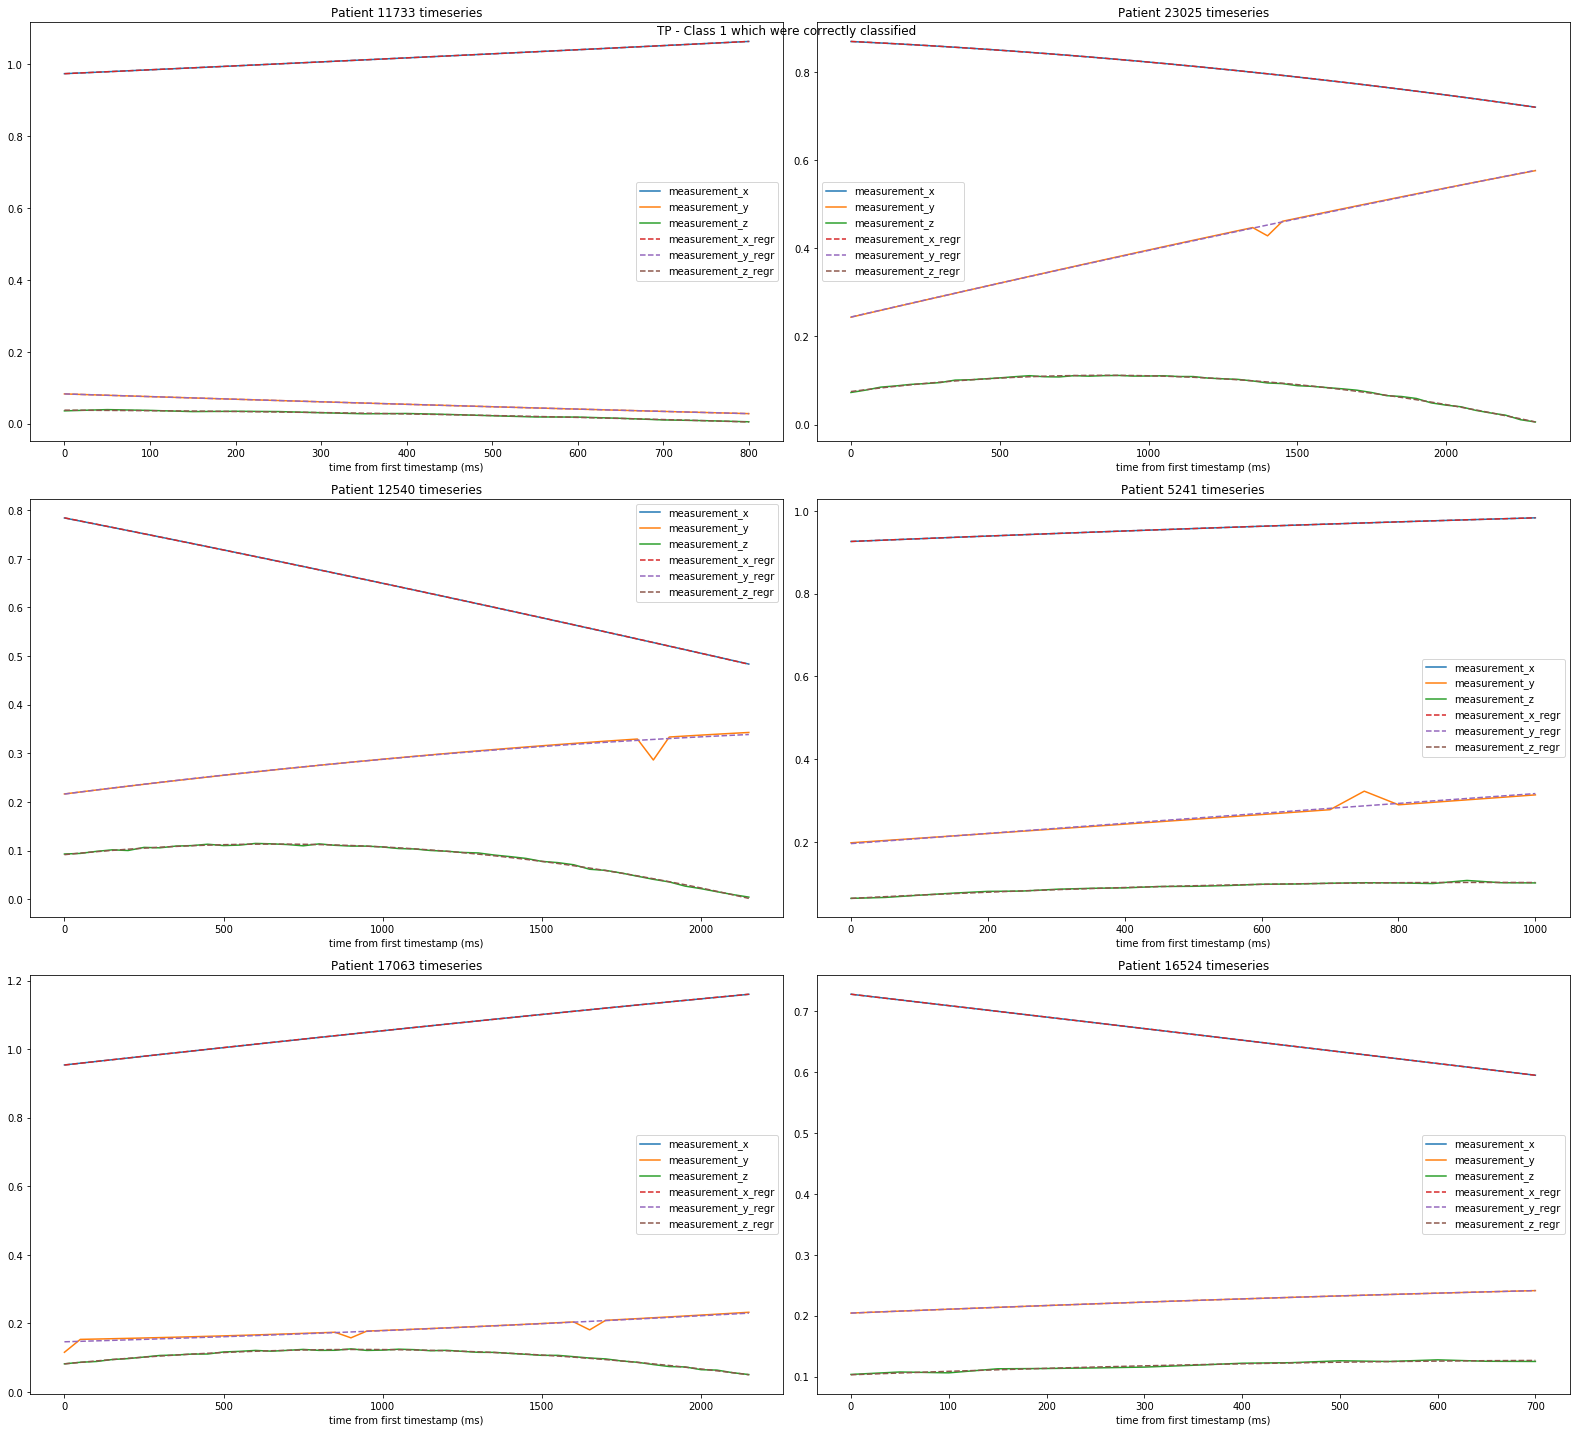

In [110]:
fig_1, axs_tp = plt.subplots(3,2)
fig_1.set_size_inches(22, 20)

plot_patient_lines(X_test_tp_class_1_orig_inds[10], extracted_features = X_test_tp_class_1[10], plot_ax = axs_tp[0,0])
plot_patient_lines(X_test_tp_class_1_orig_inds[31], extracted_features = X_test_tp_class_1[31], plot_ax = axs_tp[0,1])
plot_patient_lines(X_test_tp_class_1_orig_inds[92], extracted_features = X_test_tp_class_1[92], plot_ax = axs_tp[1,0])
plot_patient_lines(X_test_tp_class_1_orig_inds[103], extracted_features = X_test_tp_class_1[103], plot_ax = axs_tp[1,1])
plot_patient_lines(X_test_tp_class_1_orig_inds[206], extracted_features = X_test_tp_class_1[206], plot_ax = axs_tp[2,0])
plot_patient_lines(X_test_tp_class_1_orig_inds[217], extracted_features = X_test_tp_class_1[217], plot_ax = axs_tp[2,1])
plt.tight_layout()
fig_1.suptitle("TP - Class 1 which were correctly classified \n");

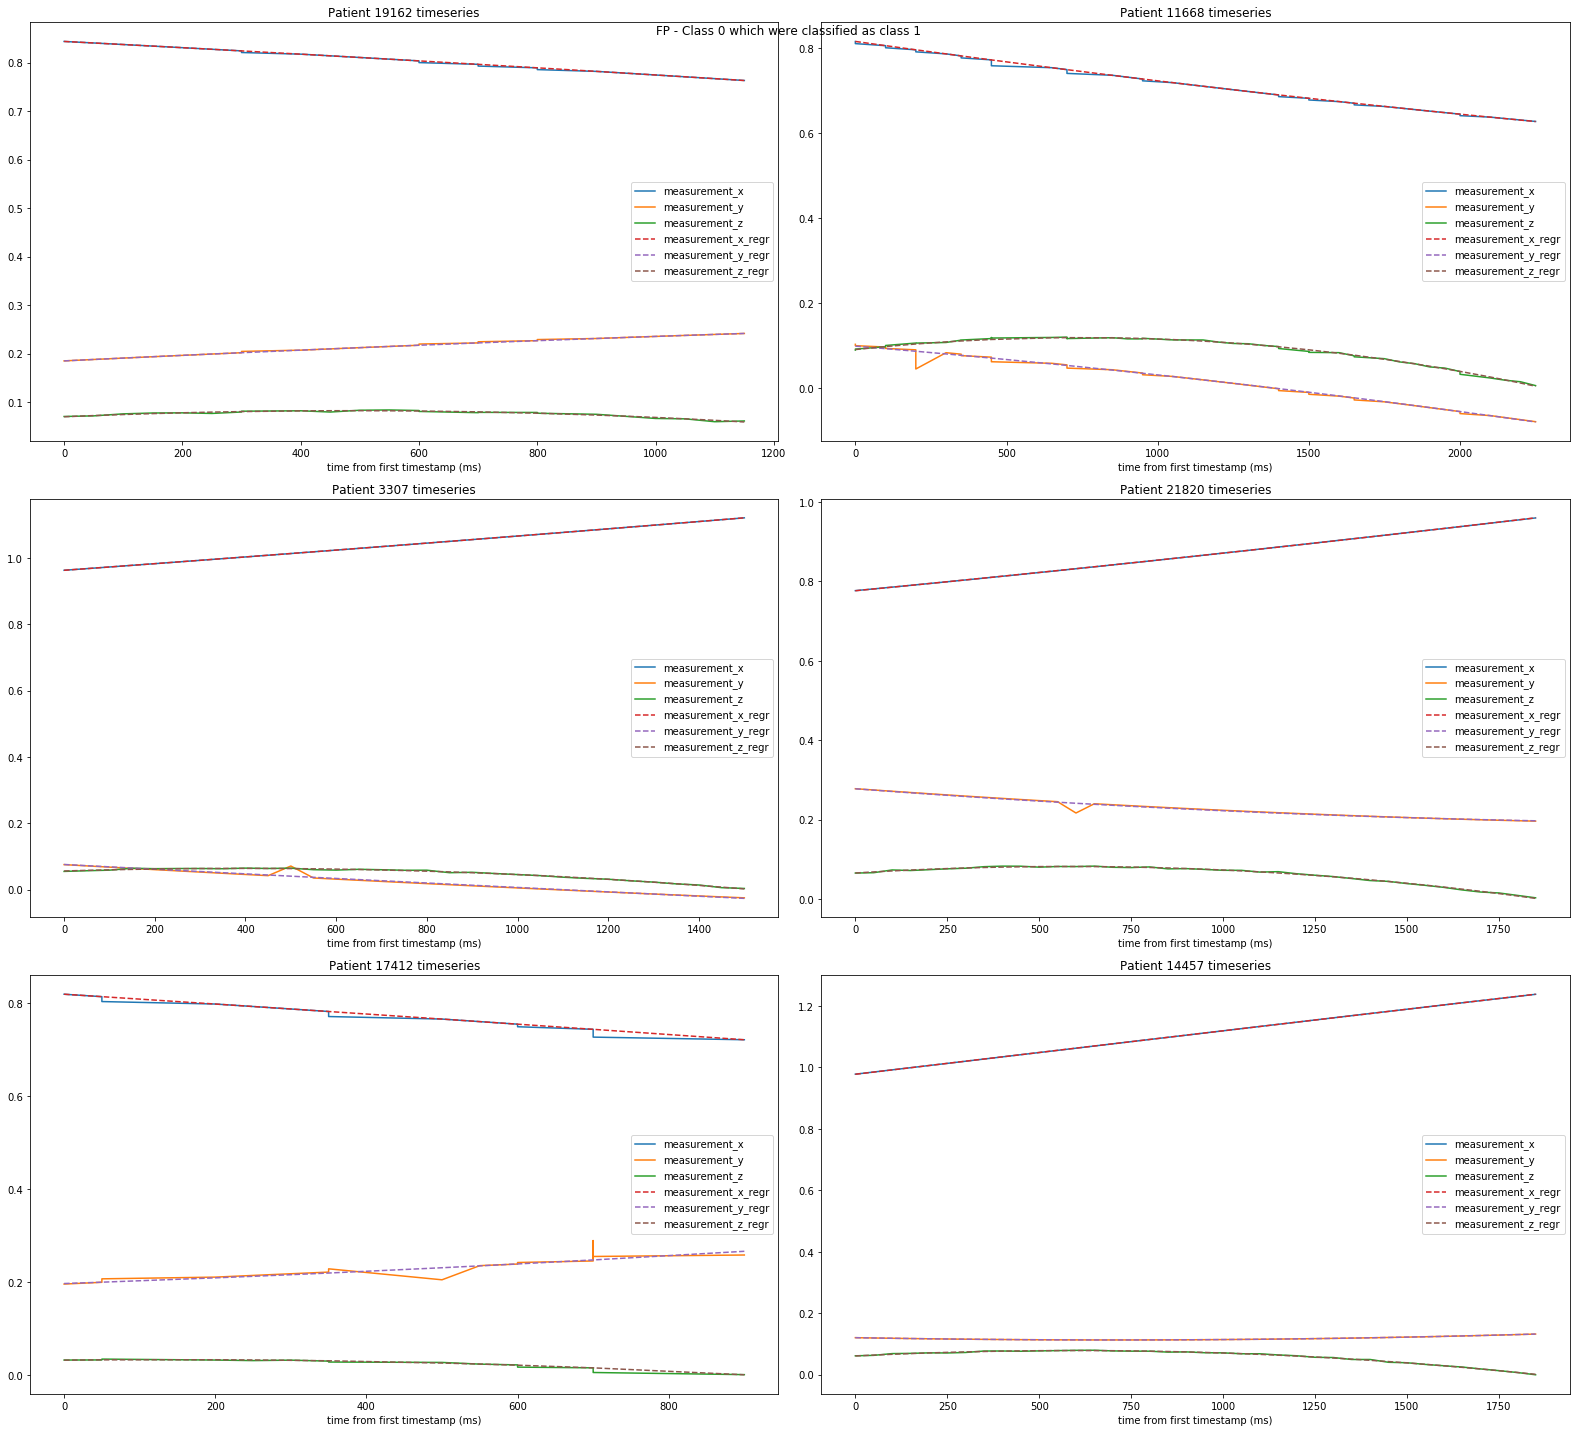

In [111]:
fig_0, axs_fp = plt.subplots(3,2)
fig_0.set_size_inches(22, 20)
fig_0.suptitle("FP - Class 0 which were classified as class 1")
plot_patient_lines(X_test_fp_0_class_1_orig_inds[0], extracted_features = X_test_fp_0_class_1[0], plot_ax = axs_fp[0,0])
plot_patient_lines(X_test_fp_0_class_1_orig_inds[1], extracted_features = X_test_fp_0_class_1[1], plot_ax = axs_fp[0,1])
plot_patient_lines(X_test_fp_0_class_1_orig_inds[2], extracted_features = X_test_fp_0_class_1[2], plot_ax = axs_fp[1,0])
plot_patient_lines(X_test_fp_0_class_1_orig_inds[3], extracted_features = X_test_fp_0_class_1[3], plot_ax = axs_fp[1,1])
plot_patient_lines(X_test_fp_0_class_1_orig_inds[-1], extracted_features = X_test_fp_0_class_1[-1], plot_ax = axs_fp[2,0])
plot_patient_lines(X_test_fp_0_class_1_orig_inds[-2], extracted_features = X_test_fp_0_class_1[-2], plot_ax = axs_fp[2,1])

plt.tight_layout()

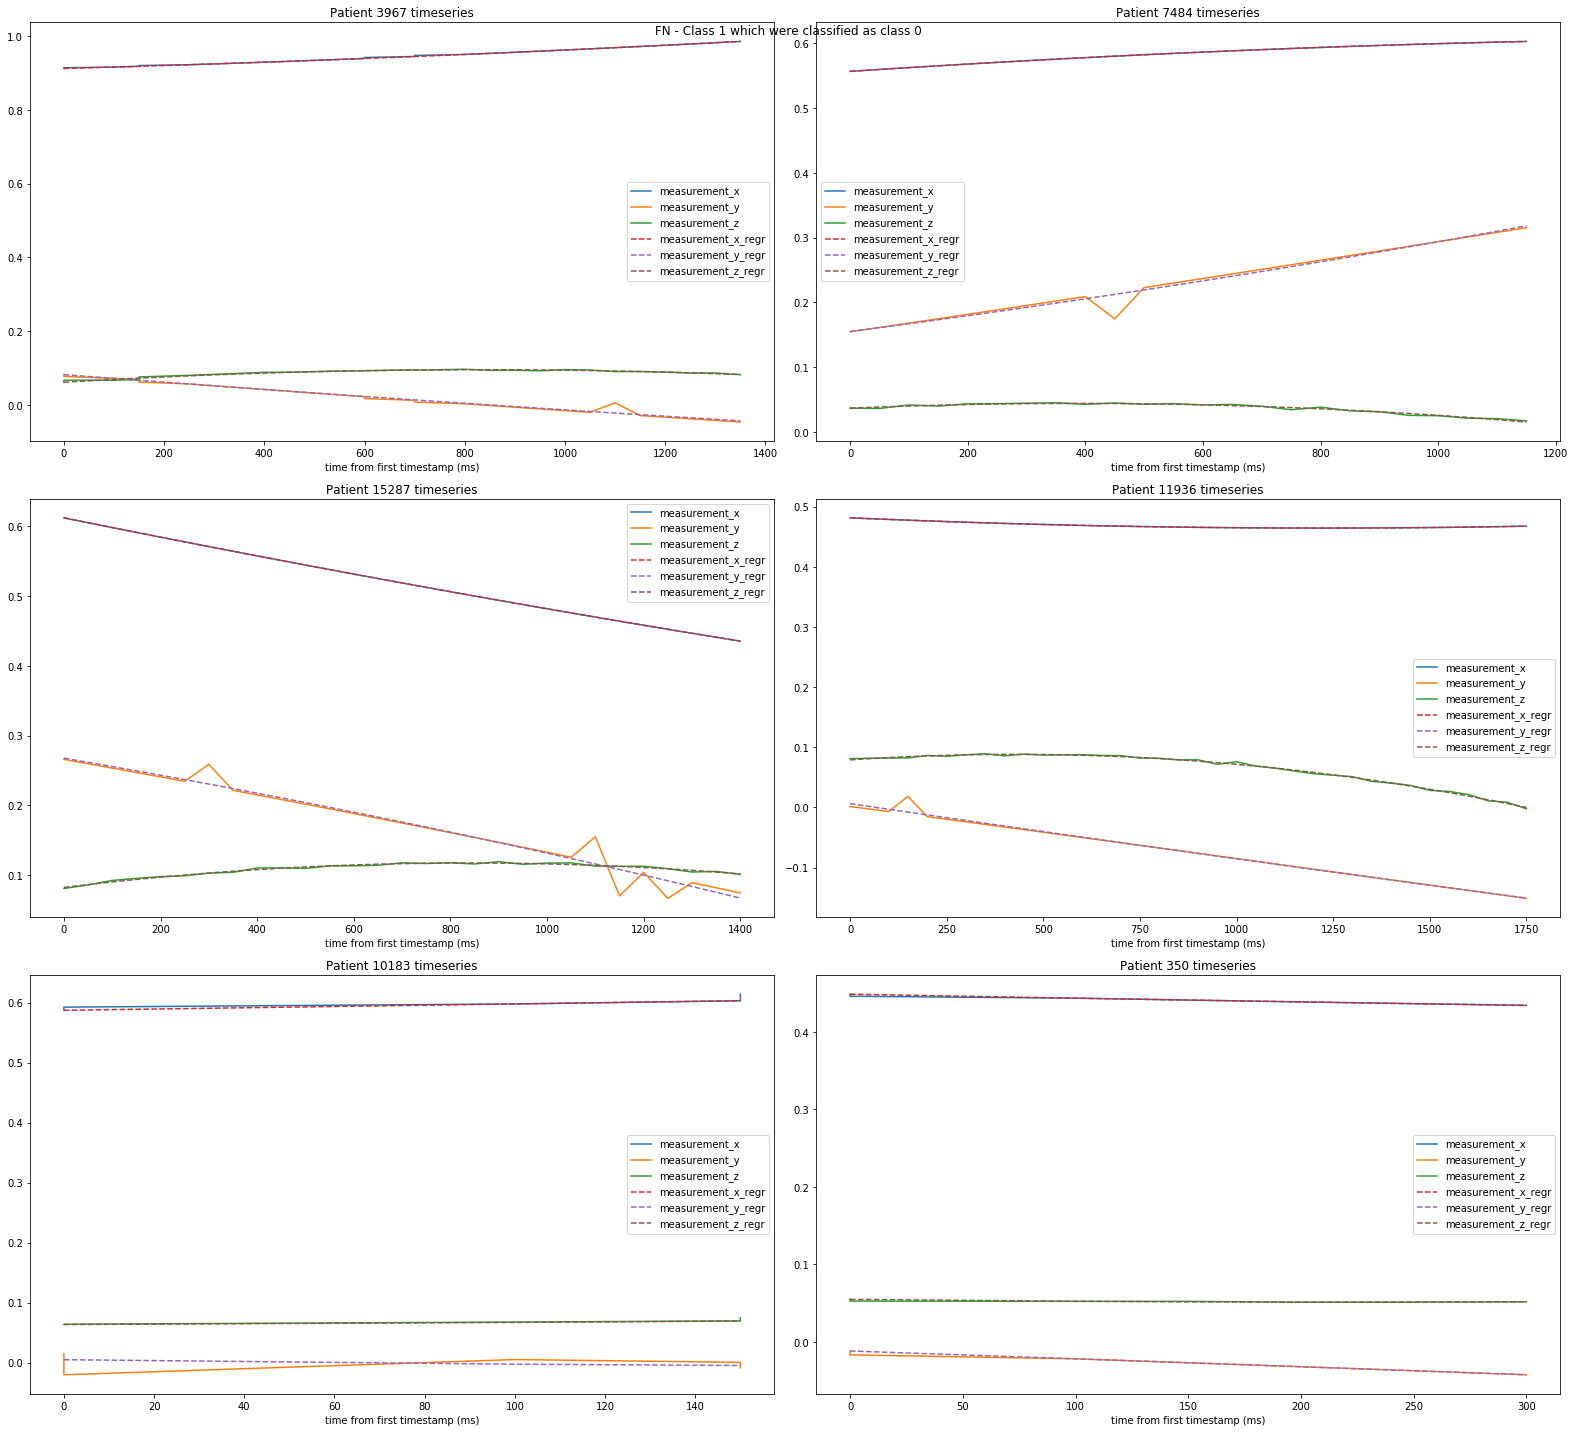

In [112]:
fig_0, axs_fp = plt.subplots(3,2)
fig_0.set_size_inches(22, 20)
fig_0.suptitle("FN - Class 1 which were classified as class 0")
plot_patient_lines(X_test_fn_0_class_1_orig_inds[0], extracted_features = X_test_fn_0_class_1[0], plot_ax = axs_fp[0,0])
plot_patient_lines(X_test_fn_0_class_1_orig_inds[1], extracted_features = X_test_fn_0_class_1[1], plot_ax = axs_fp[0,1])
plot_patient_lines(X_test_fn_0_class_1_orig_inds[2], extracted_features = X_test_fn_0_class_1[2], plot_ax = axs_fp[1,0])
plot_patient_lines(X_test_fn_0_class_1_orig_inds[3], extracted_features = X_test_fn_0_class_1[3], plot_ax = axs_fp[1,1])
plot_patient_lines(X_test_fn_0_class_1_orig_inds[-1], extracted_features = X_test_fn_0_class_1[-1], plot_ax = axs_fp[2,0])
plot_patient_lines(X_test_fn_0_class_1_orig_inds[-2], extracted_features = X_test_fn_0_class_1[-2], plot_ax = axs_fp[2,1])

plt.tight_layout()

**###################### Additions after submissions ####################**

In [15]:
tuned_classifiers['random_forest'].

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:


dot_data = tree.export_graphviz(tuned_classifiers['random_forest'].estimators_[0], out_file=None, 
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("estimator_0")

'estimator_0.pdf'

In [24]:
dot_data = tree.export_graphviz(tuned_classifiers['random_forest'].estimators_[100], out_file=None, 
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("estimator_100")

'estimator_100.pdf'

In [21]:
X_train_scaled.shape[0]/3

6854.666666666667

In [41]:
tr = tuned_classifiers['random_forest'].estimators_[100].tree_
print(f"num_nodes in tree {tr.node_count}")
print(tr.value.shape)
# print(tr.n_node_samples)
print(tr.value[0])
print(tr.n_node_samples[0])
print(tr.__dir__())

num_nodes in tree 979
(979, 1, 3)
[[6896.03313217 6778.87119689 6718.02879291]]
13010
['__new__', '__reduce__', '__getstate__', '__setstate__', 'predict', 'apply', 'decision_path', 'compute_feature_importances', 'compute_partial_dependence', 'n_classes', 'children_left', 'children_right', 'n_leaves', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'value', 'n_features', 'n_outputs', 'max_n_classes', 'max_depth', 'node_count', 'capacity', '__doc__', '__pyx_vtable__', '__repr__', '__hash__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__init__', '__reduce_ex__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']


In [81]:
tuned_classifiers['random_forest'].predict_proba(X_test_scaled)

array([[1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       ...,
       [0.995, 0.005, 0.   ],
       [1.   , 0.   , 0.   ],
       [0.005, 0.995, 0.   ]])

'xgb_tree.pdf'

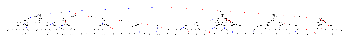

In [15]:
xgb_clf = tuned_classifiers['xgboost']
xgb.plot_tree(tuned_classifiers['xgboost'])
dot_data_xg = xgb.to_graphviz(tuned_classifiers['xgboost'])
graph = graphviz.Source(dot_data_xg)  
graph.render("xgb_tree")

In [19]:
xgb_clf.objective

'multi:softprob'

In [65]:
tr_xg = tuned_classifiers['xgboost'].estimators_[100].tree_
print(f"num_nodes in tree {tr_xg.node_count}")
print(tr_xg.value.shape)
# print(tr.n_node_samples)
print(tr_xg.value[0])
print(tr_xg.n_node_samples[0])
print(tr_xg.__dir__())

AttributeError: 'XGBClassifier' object has no attribute 'estimators_'

In [32]:
# tuned_classifiers['xgboost'].__dir__()

In [66]:
print(tuned_classifiers['xgboost'].n_estimators)
tuned_classifiers['xgboost'].get_booster()

1000


In [73]:
arr = np.array([1,2,3])

In [77]:
arr.take([1, 0, 2])

array([2, 1, 3])

# Concluding comments

* This work consists of:
    -  EDA and data visualizations 
    - Feature extraction 
    - Model training and CV test
    - Evaluation (on the training set)
        - Feature importance
        - Recall/Precision and F1
        - Confusion matrix 


* I've used 3 classifiers: SVM with gaussian kernal, random forest and xgboost. Random forest performed best. Initially I've tried simpler classifiers: LogisticRegression, DecisionTree and KNN, which yielded lower performance metrics. I've omitted them in order not to overload this work.


* Things can always be improved. Optional such improvements:
 - Produce additional features, such as: intersection of a patient timeseries, average distane between two series, 0 or other level crossings. I've planned to do so, but in view of the high resulting performance I've found this redundant.
 - Weigh signals based on their duration (a signal of 4 timestamps is less indicative than a 30 samples one). Additionally - apply classification on only the subset of signals with more than M timestamp and show scores over this set. In view of the features importance, indicating that the intercepts of each of the signals are the more significat ones, I haven't pursued this direction. 
 
This has been a good learning opportunity for me - hope you like the result...

Matan. 

# Interview preparation

Q. Why random forest went better than XGboost?

A. One possibility: ensemble methods work well with fully developed, complex trees, whereas boosting works better with small trees. When working with a single tree, as well as doing the grid search over the forest, I saw that the trees tended to be large - maybe that's the reason. After revising: when adding n_estimators to cv grid - xgboost did better.

Q. Explain the general principles behind each of the schems you've chosen to work with, and why you've chosen to work with them

A. In general, I've chosen to work with methods which don't require special treatment of imbalanced, multiple classes classification.
- SVM: Two main characteristics:
  1. Constructs the decision boundary so that it maximizes the minimal distance between instances of classes. The exact behavior depends on the regularization parameter.
  2. Using kernels enables mapping of the problem to higher dimensions, in which the points are linearly separable.
  3. The decision boundary is determined based on the support vectors, or the classes datapoints at nearest to the boundary (and are not affected by interenal points). This can make SVM susceptible to highly imbalanced data, when the rare class samlples don't include enough samples from the distribution's tail. In our case, there was no extreme imbalance, thus a mild tail sampling can be compensated by increasing the regularization parameter (thus enforcing each sample to be within the boundary). It's also possible to adjust the regularization parameter per class by [multiplying it by the class proportion](https://machinelearningmastery.com/cost-sensitive-svm-for-imbalanced-classification/)
  4. In general, if there's enough data to capture the distribution - imbalance doesn't have a significant effect.
- Random forest:

 1. In general, trees can perform multiclass classification inherently.
 2. [A paper on how to work with random forest and imbalanced data](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf) 

- XGboost:
 - [Dealing with imbalanced data]: (https://machinelearningmastery.com/xgboost-for-imbalanced-classification/) (basically weighing so that the gradient is larger for errors due to the minority class )

In [35]:
18 features, xgb classifier

[26]


## Cross validation examination ##
1. why do I get in the printouts sometimes 0.924 min_f1_score, but I don't see it in the overall results?
2. How come the evaluation over the test set is better than the cv?

In [204]:
tuned_classifier = tuned_classifiers['xgboost'].steps[-1][-1]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
use_pipeline = False
# evaluate model
classfier_to_use = tuned_classifier if not use_pipeline else\
    Pipeline(steps =  [('over', SMOTE()),
#                        ('under', RandomUnderSampler(sampling_strategy={0: 2500}) ), 
                       ('model', tuned_classifier)])
scores = cross_val_score(classfier_to_use, X_train_scaled, y_train, scoring=score_min_f1, cv=cv, n_jobs=-1)


# summarize performance
# print('Mean ROC AUC: %.5f' % mean(scores))
print( scores )
print(np.mean(scores))

[0.88265306 0.89724311 0.87206266 0.89826303 0.87309645]
0.8846636612350169


In [38]:
(x).dot(y)

26

In [153]:


# steps = [('over', SMOTE()), ('under', RandomUnderSampler() ), ('model',  xgb.XGBClassifier())]
# pipeline = Pipeline(steps=steps)
# dct = { 
#     'over__sampling_strategy' : [{1:2000}],
#     'under__sampling_strategy' : [{0:2500}],
#     'model__reg_lambda' : [ 10 ],
#     'model__max_depth': [ 20], 
#     'model__n_jobs' : [6], 
#     'model__n_estimators' :[1500]
#                                }

# clf = GridSearchCV(
#             pipeline, dct, scoring=score_min_f1,
#             verbose=10, 
#             n_jobs=6
#         )
# clf.fit(X_train_scaled, y_train)


#################
TRAIN: [   0    1    2 ... 5032 5033 5034] TEST: [   5    8   15 ... 5019 5023 5029]
Classes proportions in given set: 0: 69.17%, 1: 20.63%, 2: 10.20%
Classes proportions in given set: 0: 71.20%, 1: 18.37%, 2: 10.43%
Classes proportions in given set: 0: 33.33%, 1: 33.33%, 2: 33.33%


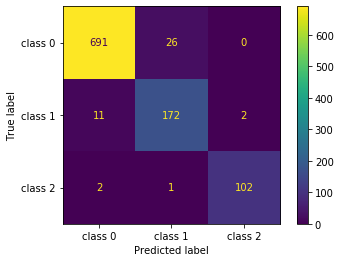

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       717
           1       0.86      0.93      0.90       185
           2       0.98      0.97      0.98       105

    accuracy                           0.96      1007
   macro avg       0.94      0.95      0.95      1007
weighted avg       0.96      0.96      0.96      1007

#################
TRAIN: [   0    1    4 ... 5031 5032 5034] TEST: [   2    3   19 ... 5009 5021 5033]
Classes proportions in given set: 0: 69.41%, 1: 20.26%, 2: 10.33%
Classes proportions in given set: 0: 70.21%, 1: 19.86%, 2: 9.93%
Classes proportions in given set: 0: 33.33%, 1: 33.33%, 2: 33.33%


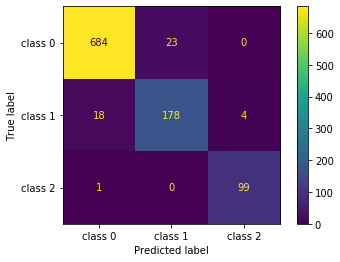

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       707
           1       0.89      0.89      0.89       200
           2       0.96      0.99      0.98       100

    accuracy                           0.95      1007
   macro avg       0.94      0.95      0.94      1007
weighted avg       0.95      0.95      0.95      1007

#################
TRAIN: [   0    1    2 ... 5031 5033 5034] TEST: [   4    6   11 ... 5026 5030 5032]
Classes proportions in given set: 0: 70.63%, 1: 19.27%, 2: 10.10%
Classes proportions in given set: 0: 65.34%, 1: 23.83%, 2: 10.82%
Classes proportions in given set: 0: 33.33%, 1: 33.33%, 2: 33.33%


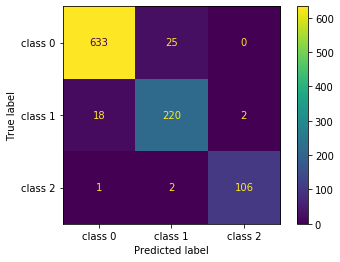

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       658
           1       0.89      0.92      0.90       240
           2       0.98      0.97      0.98       109

    accuracy                           0.95      1007
   macro avg       0.95      0.95      0.95      1007
weighted avg       0.95      0.95      0.95      1007

#################
TRAIN: [   2    3    4 ... 5030 5032 5033] TEST: [   0    1    7 ... 5024 5031 5034]
Classes proportions in given set: 0: 69.66%, 1: 20.21%, 2: 10.13%
Classes proportions in given set: 0: 69.22%, 1: 20.06%, 2: 10.72%
Classes proportions in given set: 0: 33.33%, 1: 33.33%, 2: 33.33%


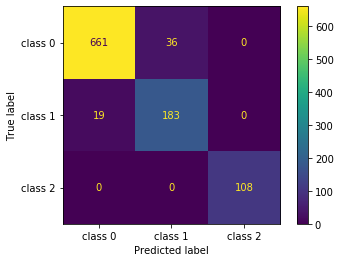

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       697
           1       0.84      0.91      0.87       202
           2       1.00      1.00      1.00       108

    accuracy                           0.95      1007
   macro avg       0.94      0.95      0.94      1007
weighted avg       0.95      0.95      0.95      1007

#################
TRAIN: [   0    1    2 ... 5032 5033 5034] TEST: [   9   10   14 ... 5018 5027 5028]
Classes proportions in given set: 0: 68.99%, 1: 20.53%, 2: 10.48%
Classes proportions in given set: 0: 71.90%, 1: 18.77%, 2: 9.33%
Classes proportions in given set: 0: 33.33%, 1: 33.33%, 2: 33.33%


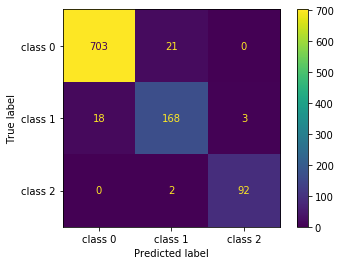

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       724
           1       0.88      0.89      0.88       189
           2       0.97      0.98      0.97        94

    accuracy                           0.96      1007
   macro avg       0.94      0.95      0.94      1007
weighted avg       0.96      0.96      0.96      1007



In [201]:
oversample = SMOTE()
undersample = RandomUnderSampler(sampling_strategy={0: 2338})

for train_index, test_index in cv.split(X_train_scaled, y_train):
    print("#################")
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]
    print_classes_proportions(y_train_cv)
    print_classes_proportions(y_test_cv)
    
    X_smote_1, y_smote_1 =  oversample.fit_resample(X_train_cv, y_train_cv)
    X_train_smote, y_train_smote =  X_smote_1, y_smote_1 #undersample.fit_resample(X_smote_1, y_smote_1)
    print_classes_proportions(y_train_smote)
    y_true, y_pred_smote = y_test_cv, tuned_classifier.fit(X_train_smote, y_train_smote).predict(X_test_cv)
    plot_confusion_matrix(tuned_classifier, X_test_cv, y_true, display_labels=['class 0', 'class 1', 'class 2'], values_format='.0f')
    plt.show()
    print( classification_report(y_true, y_pred_smote) )

In [ ]:


# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)
# under = RandomUnderSampler(sampling_strategy=0.5)


X_smote_1, y_smote_1 = oversample.fit_resample(X, y)
X_smote, y_smote = undersample.fit_resample(X, y)

print_classes_proportions(y_smote)
X_train_smote, X_test_smote, y_train_smote, y_test_smote, inds_train_smote, inds_test_smote = train_test_split(X_smote, y_smote, np.arange(len(y_smote)), test_size = 0.2)
scaler_smote = preprocessing.StandardScaler().fit(X_train_smote)
X_train_scaled_smote = scaler_smote.transform(X_train_smote)
X_test_scaled_smote = scaler_smote.transform(X_test_smote)


In [233]:
# def get_classes_ratios(y):
#     n_samples = len(y)
#     return ((y==0).sum()/n_samples )

for train_index, test_index in cv.split(X_train_scaled, y_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]
    print_classes_proportions(y_train_cv)
    print_classes_proportions(y_test_cv)
    print("#################")

TRAIN: [   1    4    5 ... 5031 5032 5034] TEST: [   0    2    3 ... 5025 5026 5033]
Classes proportions in given set: 0: 70.08%, 1: 19.89%, 2: 10.03%
Classes proportions in given set: 0: 67.53%, 1: 21.35%, 2: 11.12%
#################
TRAIN: [   0    1    2 ... 5029 5031 5033] TEST: [   4   11   20 ... 5030 5032 5034]
Classes proportions in given set: 0: 69.76%, 1: 20.03%, 2: 10.20%
Classes proportions in given set: 0: 68.82%, 1: 20.75%, 2: 10.43%
#################
TRAIN: [   0    1    2 ... 5032 5033 5034] TEST: [   9   10   15 ... 5019 5023 5031]
Classes proportions in given set: 0: 68.64%, 1: 20.75%, 2: 10.60%
Classes proportions in given set: 0: 73.29%, 1: 17.87%, 2: 8.84%
#################
TRAIN: [   0    2    3 ... 5032 5033 5034] TEST: [   1    7   12 ... 5020 5022 5029]
Classes proportions in given set: 0: 69.74%, 1: 20.41%, 2: 9.86%
Classes proportions in given set: 0: 68.92%, 1: 19.27%, 2: 11.82%
#################
TRAIN: [   0    1    2 ... 5032 5033 5034] TEST: [   5    6   